In [1]:
import pymeshlab
import numpy as np
from IPython import display

## Ejercicio 1 (Shape enhancement)

In [2]:
def ring1(s,v): 
    #esta funcion calcula el anillo 1 y lo devuelve en un set 
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
    n_vertex = ms.current_mesh().vertex_number() #obtenemos el numero de vertices
    n_faces = ms.current_mesh().face_number() #obtenemos el numero de caras
    faces = ms.current_mesh().face_matrix() #guardamos las caras
    vertex = ms.current_mesh().vertex_matrix() #guardamos los vertices
    
    v_ring = set([v]) #Guarda el anillo 1 de v
    for i in range(n_faces): #Las caras en las que pertenece el vertice
        if(faces[i][0] == v):
            v_ring = v_ring.union(set([faces[i][1],faces[i][2]]))
        if(faces[i][1] == v):
            v_ring = v_ring.union(set([faces[i][0],faces[i][2]]))
        if(faces[i][2] == v):
            v_ring = v_ring.union(set([faces[i][1],faces[i][0]]))
    return v_ring

In [3]:
def K_neighbors(s, v, K): 
    #Le pasamos el string del numbre del mesh que usaremos (debe estar en la misma carpeta que este archivo))
    #Le pasamos el vertice del que queremos el anillo
    #Le pasamos el tamaño del anillo que queremos
    
    if(K == 0):
        return np.array([v])
    
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
    n_vertex = ms.current_mesh().vertex_number() #obtenemos el numero de vertices
    n_faces = ms.current_mesh().face_number() #obtenemos el numero de caras
    faces = ms.current_mesh().face_matrix() #guardamos las caras
    vertex = ms.current_mesh().vertex_matrix() #guardamos los vertices
    
    last_ring = set([v])
    v_ring = ring1(s,v) #Guarda el anillo 1 de v
    for i in range(K-1):
        new = v_ring - last_ring
        last_ring = v_ring
        for j in new:
            v_ring = v_ring.union(ring1(s,j))
    return np.array(list(v_ring))

Cree la siguiente funcion para probar que el anillo dado sea correcto.

In [4]:
def prueba_anillo(s, v, K):
#Esta funcion colorea el anillo para probar que el resultado sea correcto
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
    n_vertex = ms.current_mesh().vertex_number() #obtenemos el numero de vertices
    n_faces = ms.current_mesh().face_number() #obtenemos el numero de caras
    faces = ms.current_mesh().face_matrix() #guardamos las caras
    vertex = ms.current_mesh().vertex_matrix() #guardamos los vertices
    
    anillo = K_neighbors(s, v, K)
    colors = np.ones((n_vertex,4))
    
    for i in anillo:
        colors[i] = [0, 0, 1, 0]
    m2 = pymeshlab.Mesh(vertex_matrix=vertex, face_matrix=faces, v_color_matrix=colors)
    ms.add_mesh(m2, "ring.obj")
    ms.save_current_mesh("ring.obj")

Para ver que la funcion de anillo es correcta, vemos a continuación los resultados de la prueba.

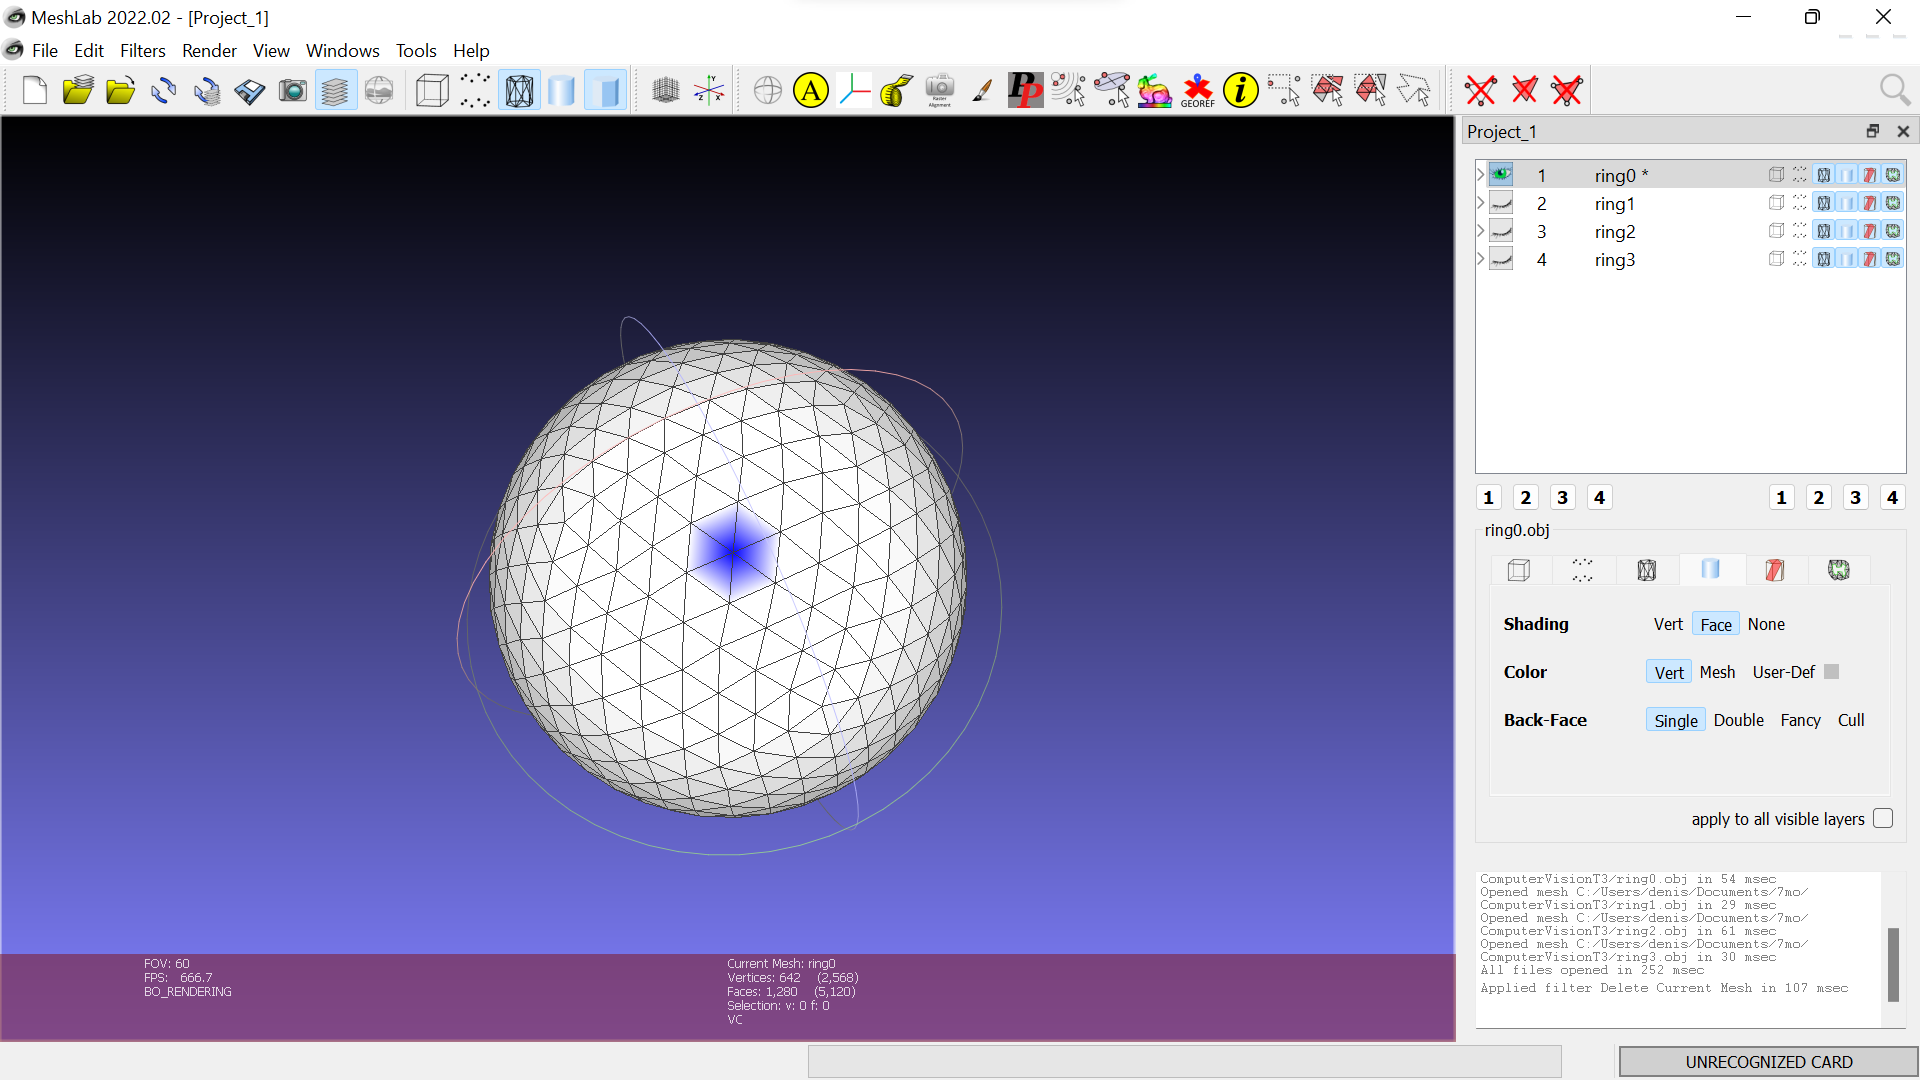

In [5]:
#Anillo 0
prueba_anillo("sphere.obj", 0, 0)
display.Image("./images/1.1.png", width=500)

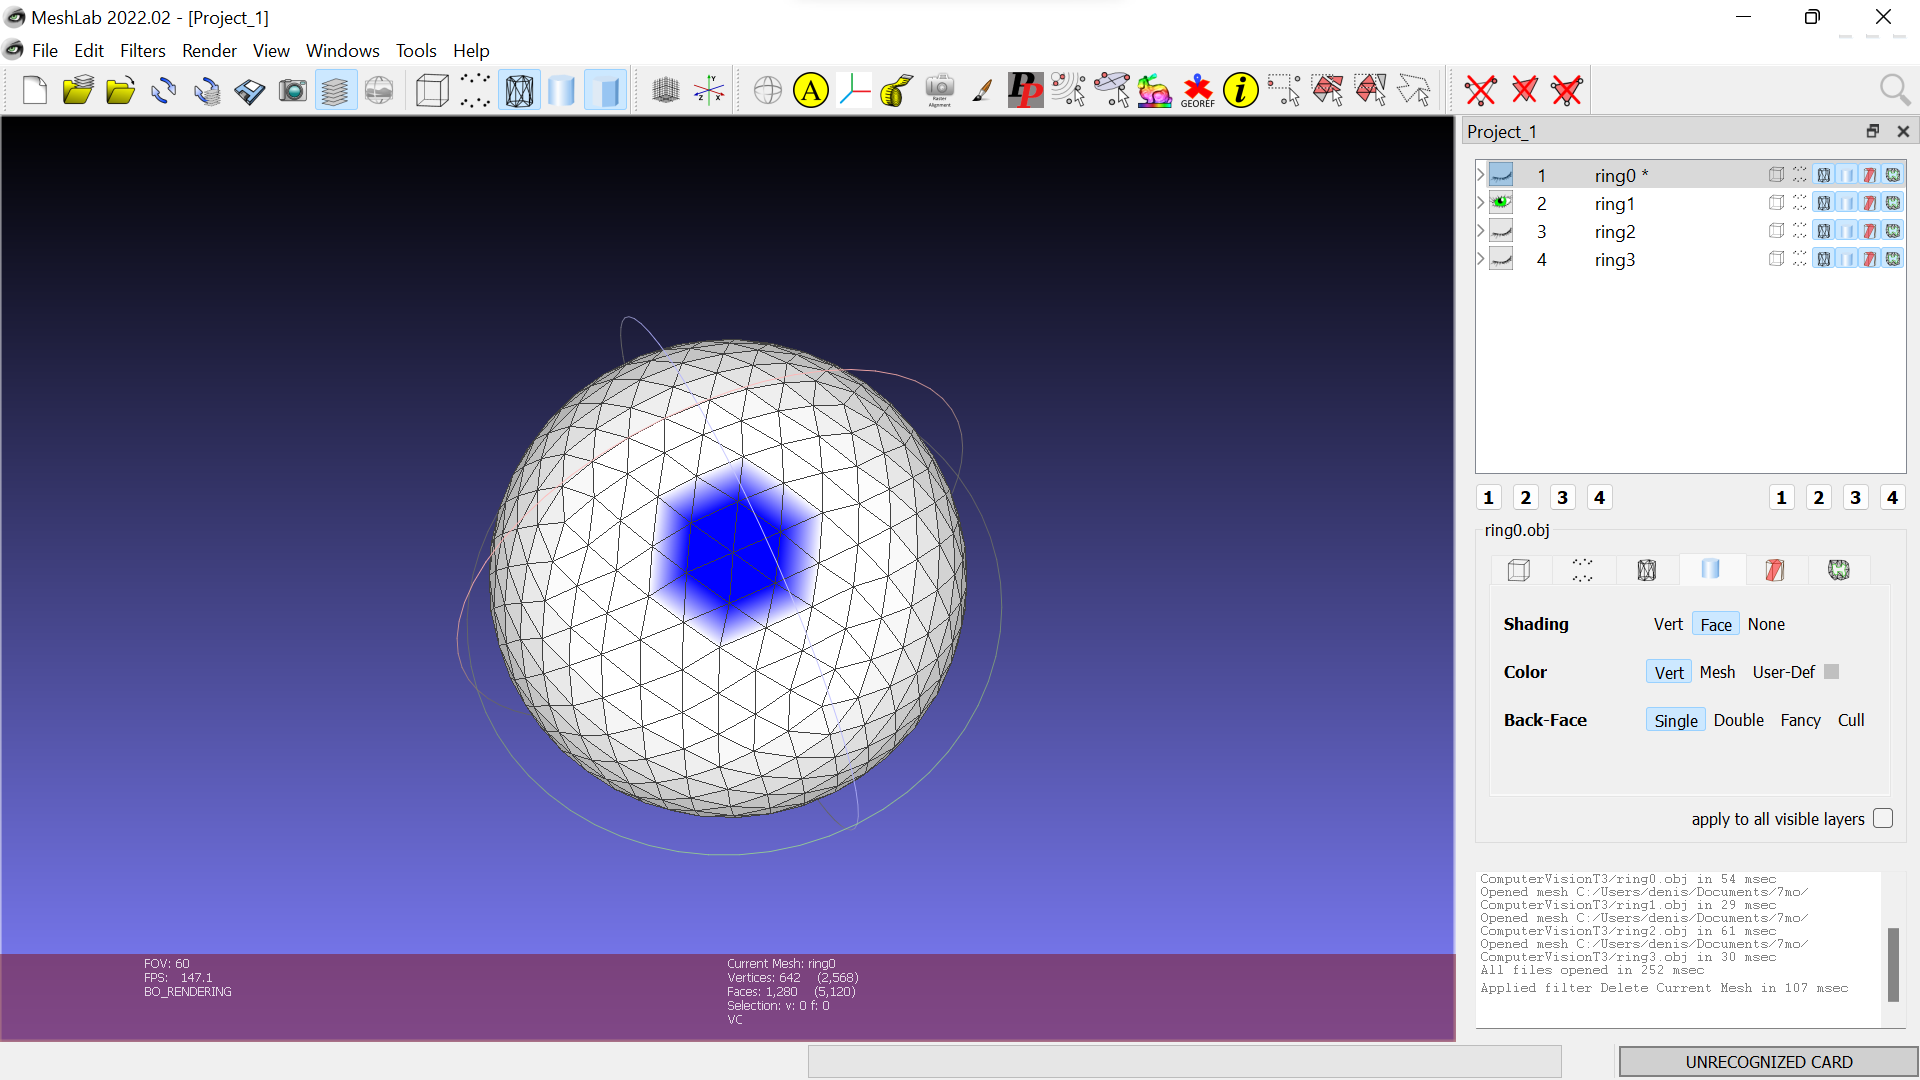

In [6]:
#Anillo 1
prueba_anillo("sphere.obj", 0, 1)
display.Image("./images/1.2.png", width=500)

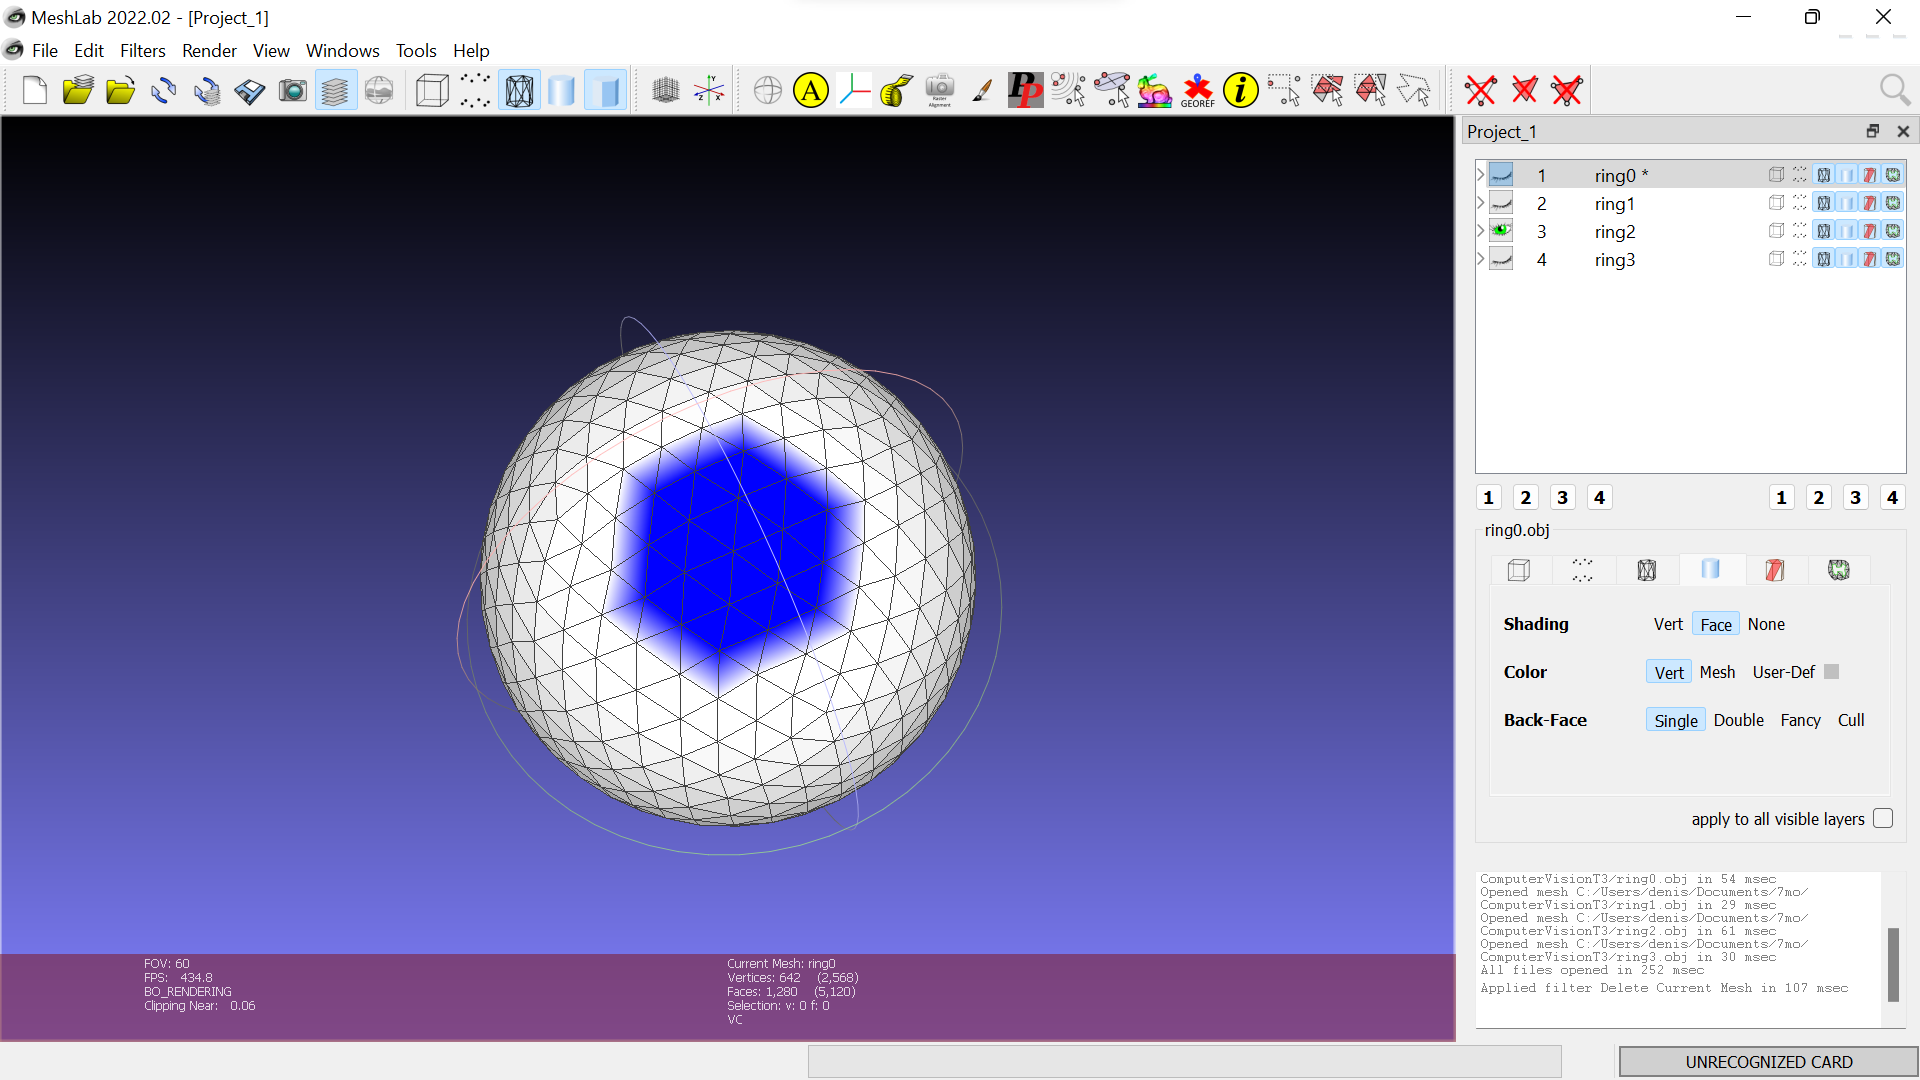

In [7]:
#Anillo 2
prueba_anillo("sphere.obj", 0, 2)
display.Image("./images/1.3.png", width=500)

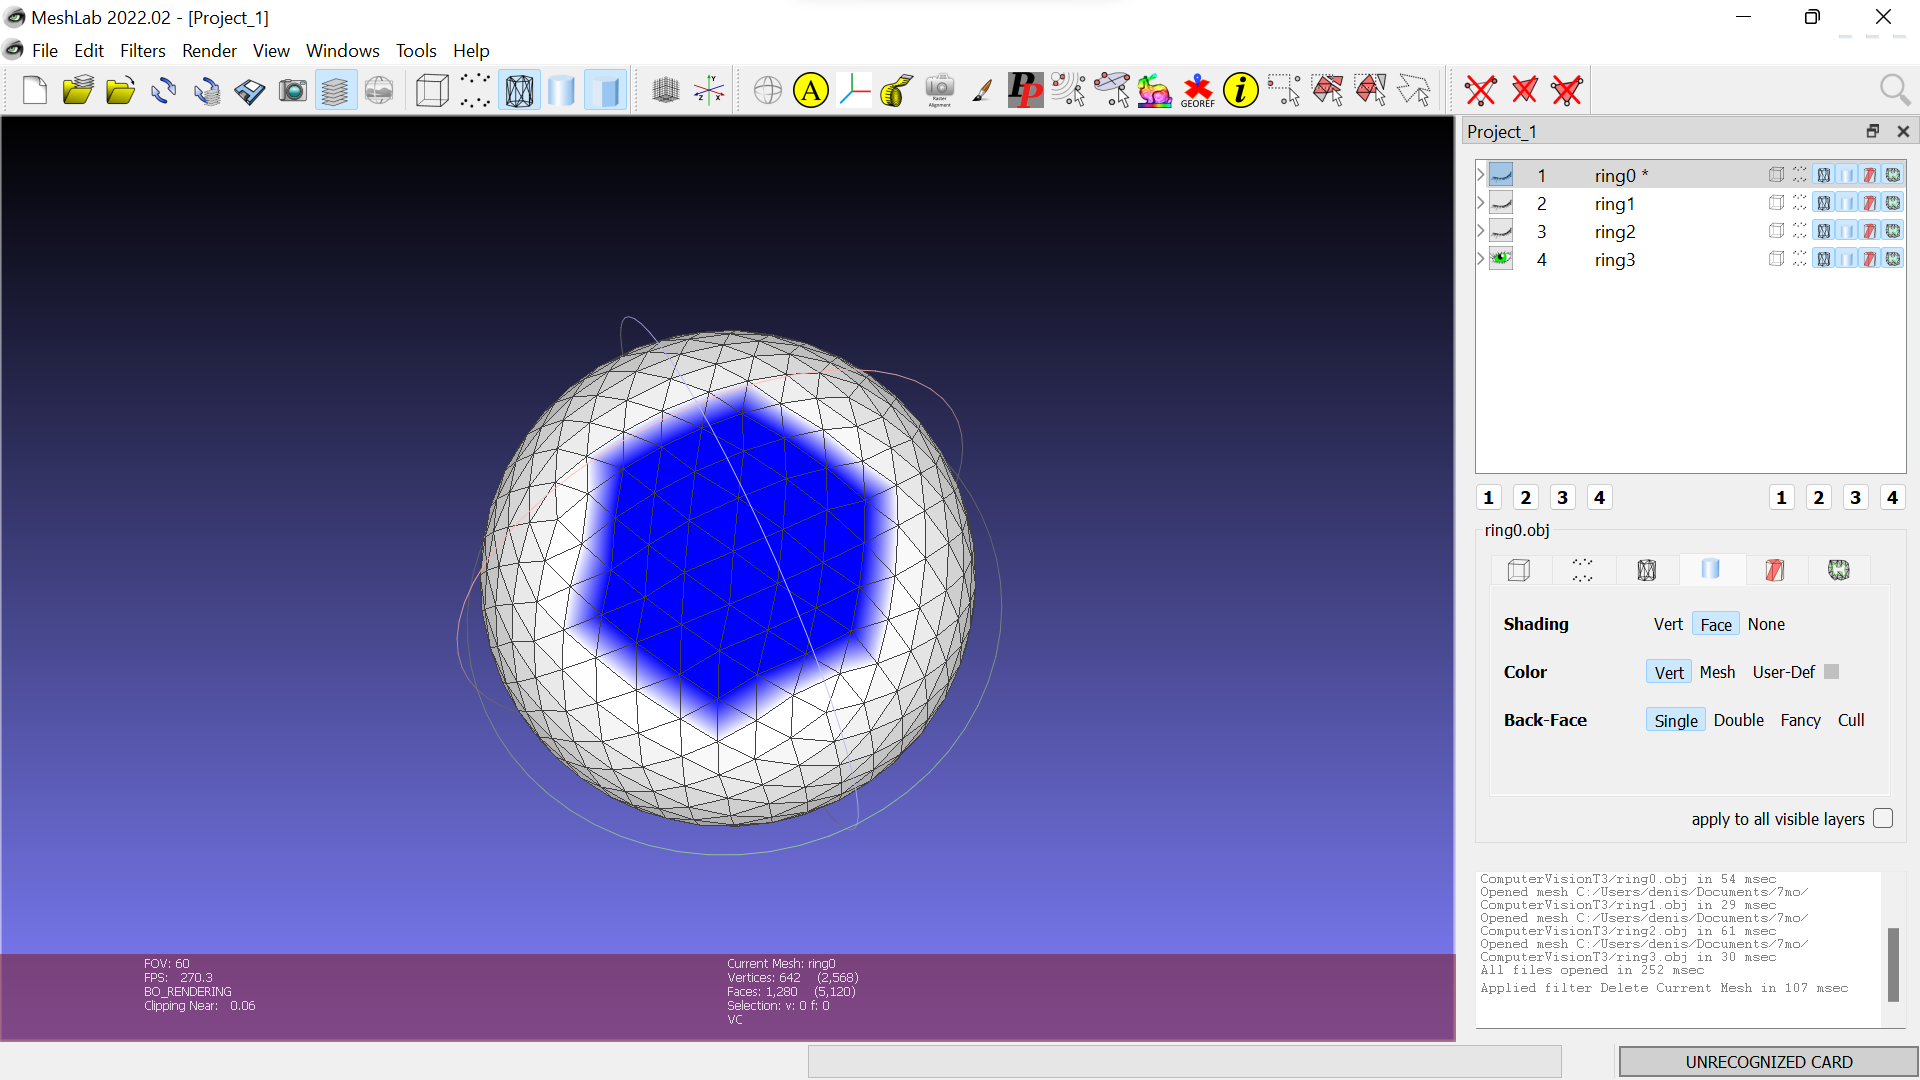

In [8]:
#Anillo 3
prueba_anillo("sphere.obj", 0, 3)
display.Image("./images/1.4.png", width=500)

Imprimamos los resultados del anillo 2.

In [9]:
n = K_neighbors("sphere.obj", 0, 2)
print(n)

[ 0  1  2  3  4  5  6  7  9 10 11 12 13 25 26 33 35 36 44]


In [10]:
def normalized_weights(s, v, K, sigma):
    suma = 0
    if(K == 0):
        return np.array([1]), np.array([v]) 
    ring = K_neighbors(s, v, K)
    ring_ = K_neighbors(s, v, K-1) #Vemos el anillo inferior
    w = np.zeros(len(ring))
    w_norm = np.zeros(len(ring))
    w_index = np.zeros(len(ring)) #nos dice cual es el vertice referido en cada indice
    cont = 0
    for i in range(K, 0, -1):
        check = np.setdiff1d(ring, ring_) #Nos muestra los que estan en un arreglo pero no en el otro
        for vert in check: #por cada vertice que este en N_K\N_{K-1}
            w[cont] = np.exp(-i**2/(2*sigma**2))
            suma += w[cont]
            w_index[cont] = np.ceil(vert) #Nos guarda que vertice corresponde a la posicion del peso
            cont += 1
        ring = ring_
        ring_ = K_neighbors(s, v, i-2)
        
    #Solo nos falta el anillo 0
    w[cont] = 1
    w_index[cont] = np.ceil(v) 
    suma += w[cont]
    
    w_norm = w/suma
    #devuelve los pesos y los indices a los que corresponden
    return w_norm, w_index

Cree esta función para probar que el anillo identifica correctamente si esta en $N_K-N_{K-1}$ cambiando de color.

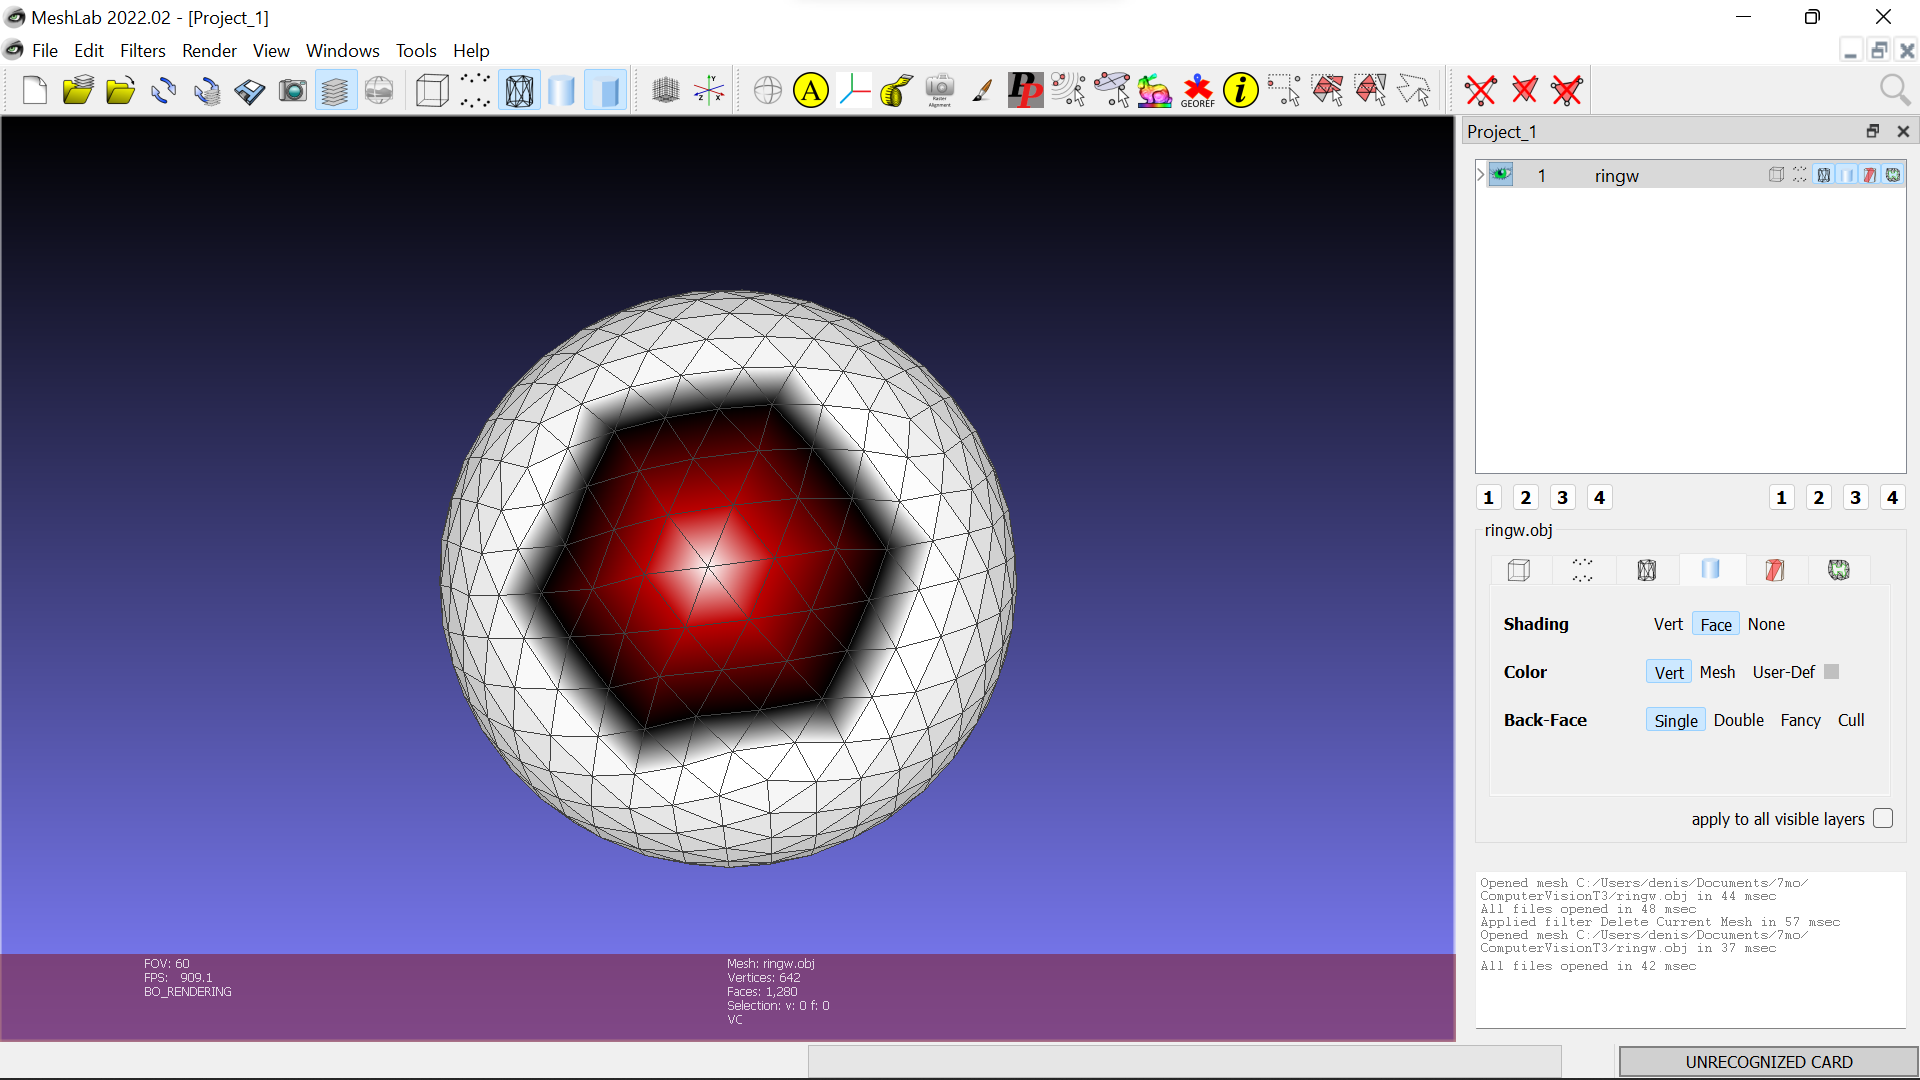

In [11]:
display.Image("./images/1.5.png", width=600)

In [12]:
def normalized_weights_prueba(s, v, K, sigma):
    suma = 0
    if(K == 0):
        return np.array([1]), np.array([v]) 
    
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
    n_vertex = ms.current_mesh().vertex_number() #obtenemos el numero de vertices
    n_faces = ms.current_mesh().face_number() #obtenemos el numero de caras
    faces = ms.current_mesh().face_matrix() #guardamos las caras
    vertex = ms.current_mesh().vertex_matrix() #guardamos los vertices
    
    anillo = K_neighbors(s, v, K)
    colors = np.ones((n_vertex,4))
    
    ring = K_neighbors(s, v, K)
    ring_ = K_neighbors(s, v, K-1) #Vemos el anillo inferior
    w = np.zeros(len(ring))
    w_norm = np.zeros(len(ring))
    w_index = np.zeros(len(ring)) #nos dice cual es el vertice referido en cada indice
    cont = 0
    
    for i in range(K, 0, -1):
        check = np.setdiff1d(ring, ring_) #Nos muestra los que estan en un arreglo pero no en el otro
        for vert in check: #por cada vertice que este en N_K\N_{K-1}
            colors[vert] = [(K-i)/K, 0, 0, 0]
            w[cont] = np.exp(-i**2/(2*sigma**2))
            suma += w[cont]
            w_index[cont] = np.ceil(vert) #Nos guarda que vertice corresponde a la posicion del peso
            cont += 1
        ring = ring_
        ring_ = K_neighbors(s, v, i-2)
    #Solo nos falta el anillo 0
    w[cont] = 1
    w_index[cont] = np.ceil(v) 
    suma += w[cont]
    
    w_norm = w/suma
    
    m2 = pymeshlab.Mesh(vertex_matrix=vertex, face_matrix=faces, v_color_matrix=colors)
    ms.add_mesh(m2, "ringw.obj")
    ms.save_current_mesh("ringw.obj")

In [13]:
normalized_weights_prueba("sphere.obj", 0, 3, 1)

In [14]:
w_norm = normalized_weights("sphere.obj", 0, 3, 1)

In [15]:
def local_weighted_mean(s, f, K, sigma):
    n_vertex = len(f)
    mu = np.zeros((n_vertex, 3))
    for v in range(n_vertex):
        aux = normalized_weights(s, v, K, sigma)
        w_norm = aux[0]
        w_index = aux[1]
        suma = 0
        for j in range(len(w_norm)):
            idx = (int)(w_index[j])
            suma += w_norm[j]*f[idx]
        mu[v] = suma
    return mu

In [16]:
def unsharp_masking_mesh(s, K, sigma, beta):
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
    n_vertex = ms.current_mesh().vertex_number() #obtenemos el numero de vertices
    vertex = ms.current_mesh().vertex_matrix() #guardamos los vertices
    enhanced = np.zeros((n_vertex,3))
    
    mu = local_weighted_mean(s, vertex, K, sigma)
    
    for i in range(n_vertex):
        enhanced[i] = vertex[i] + beta*(vertex[i] - mu[i]) 
    return enhanced

In [17]:
def construct(s, vertex, new_name):
    #le pasamos la malla de la cual sacamos la conectividad, las nuevas posiciones 
    #de los vertices y el nuevo nombre con el que guardaremos la malla
    
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
    faces = ms.current_mesh().face_matrix() #guardamos las caras
    
    m2 = pymeshlab.Mesh(vertex_matrix=vertex, face_matrix=faces)
    ms.add_mesh(m2, new_name)
    ms.save_current_mesh(new_name)

In [18]:
enhanced = unsharp_masking_mesh("cow.obj", 2, 1, 1.5)

In [19]:
construct("cow.obj", enhanced, "enhanced_cow.obj")

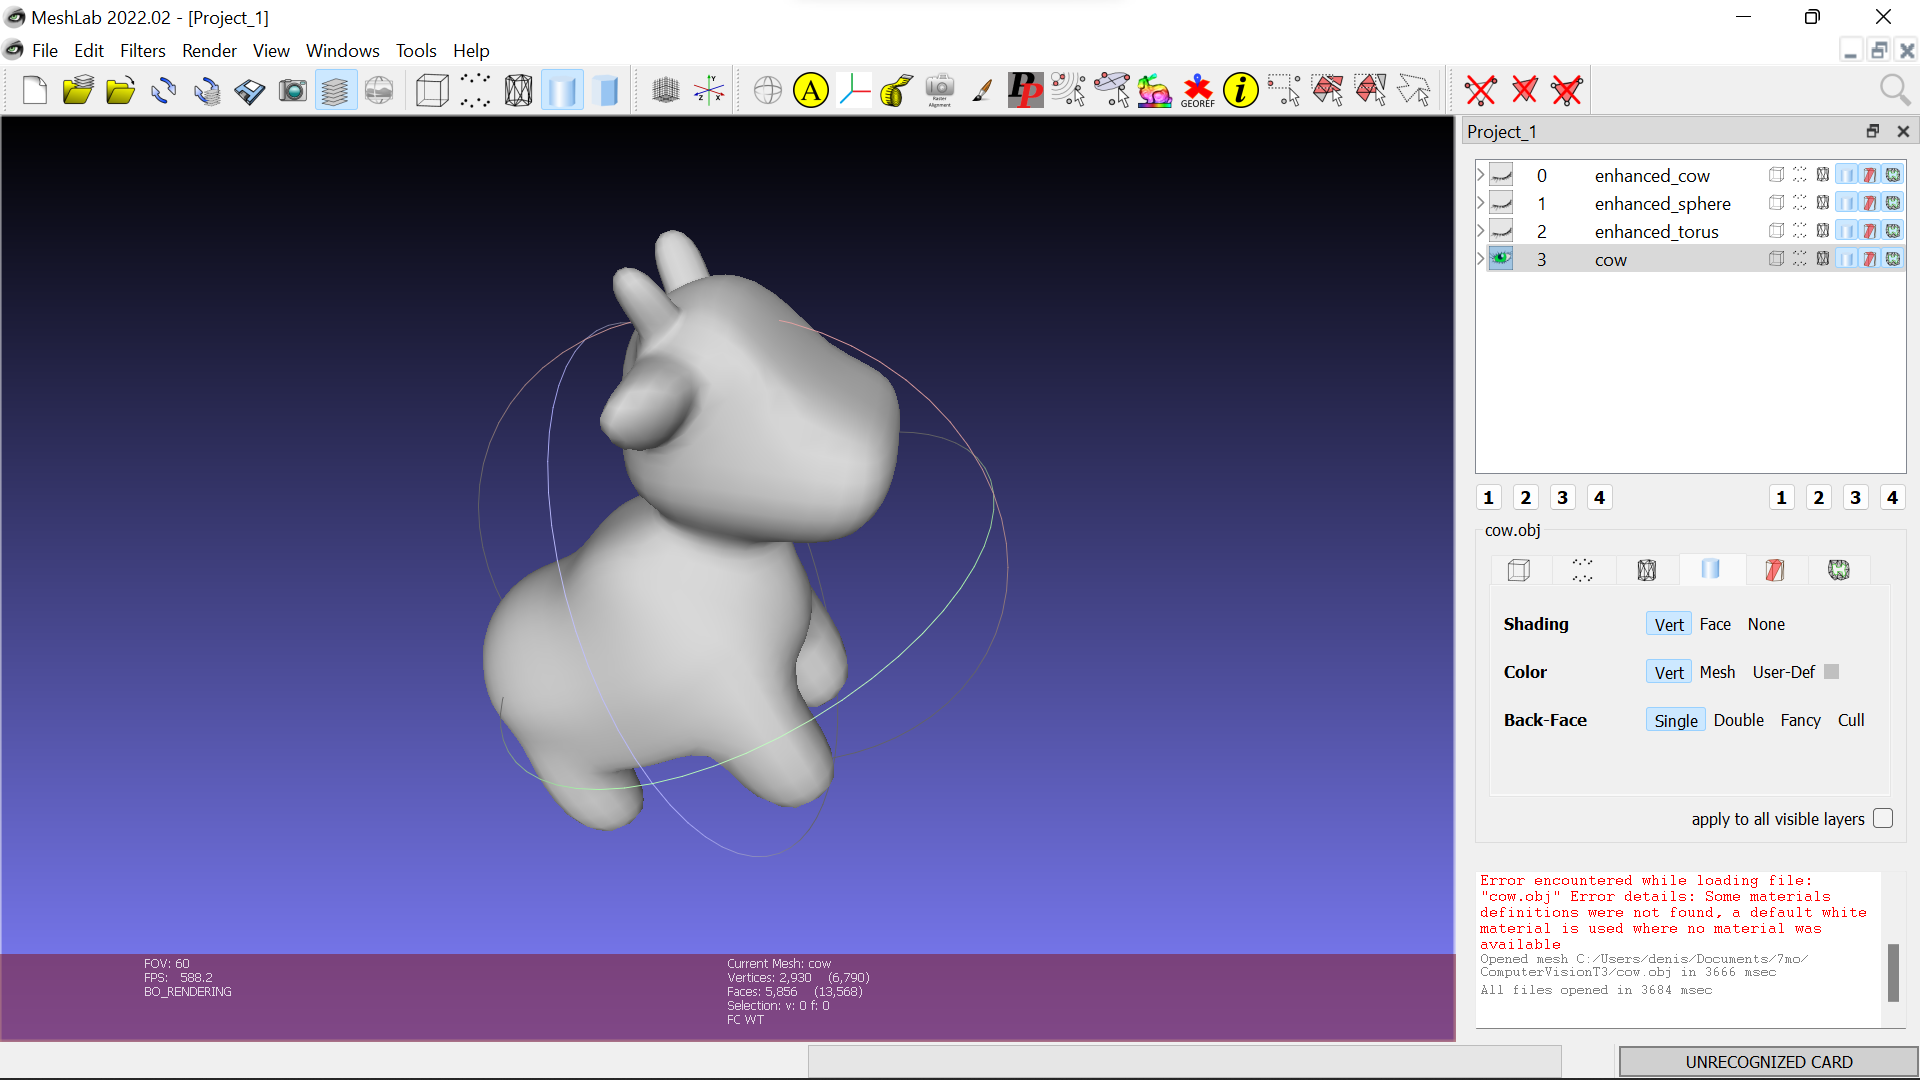

In [20]:
#Malla original
display.Image("./images/1.6.png", width=600)

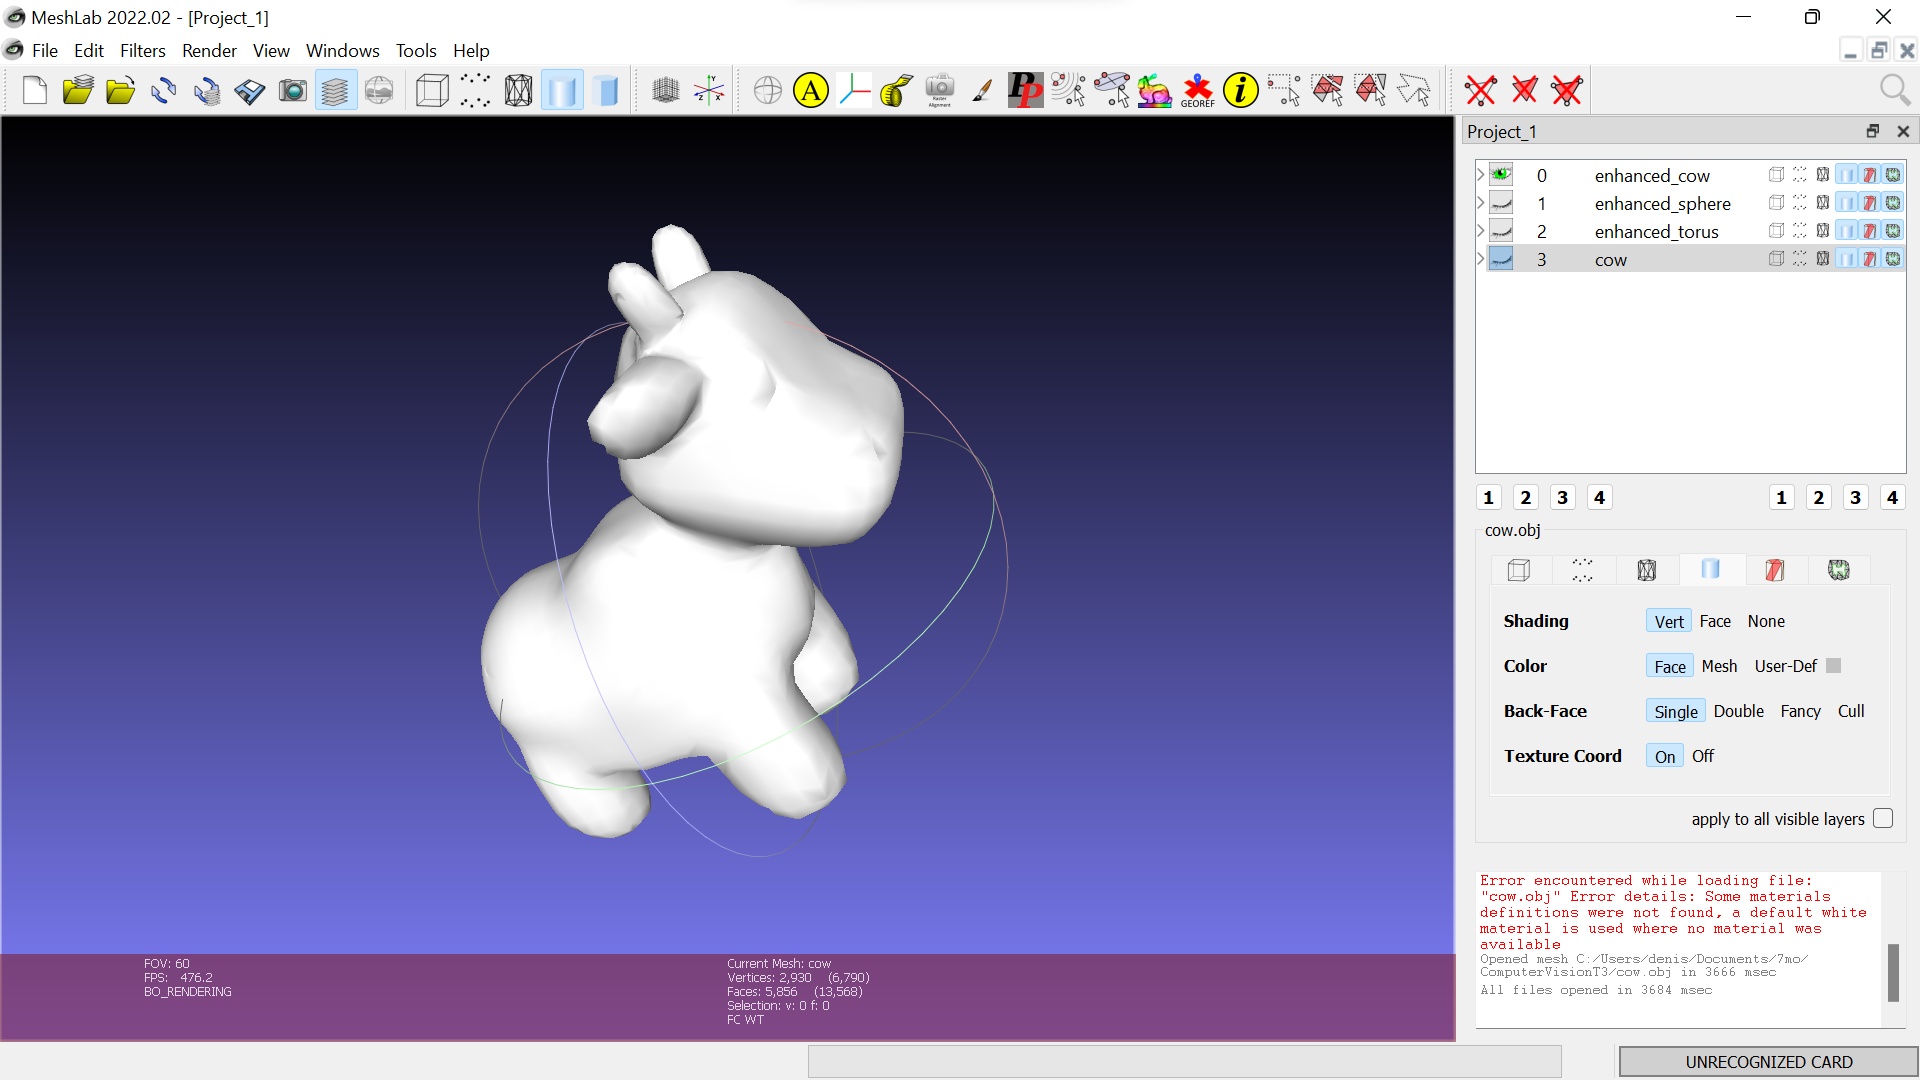

In [21]:
#Malla modificada
display.Image("./images/1.7.png", width=600)

In [22]:
enhanced_s = unsharp_masking_mesh("sphere.obj", 2, 1, 1.5)

In [23]:
construct("sphere.obj", enhanced_s, "enhanced_sphere.obj")

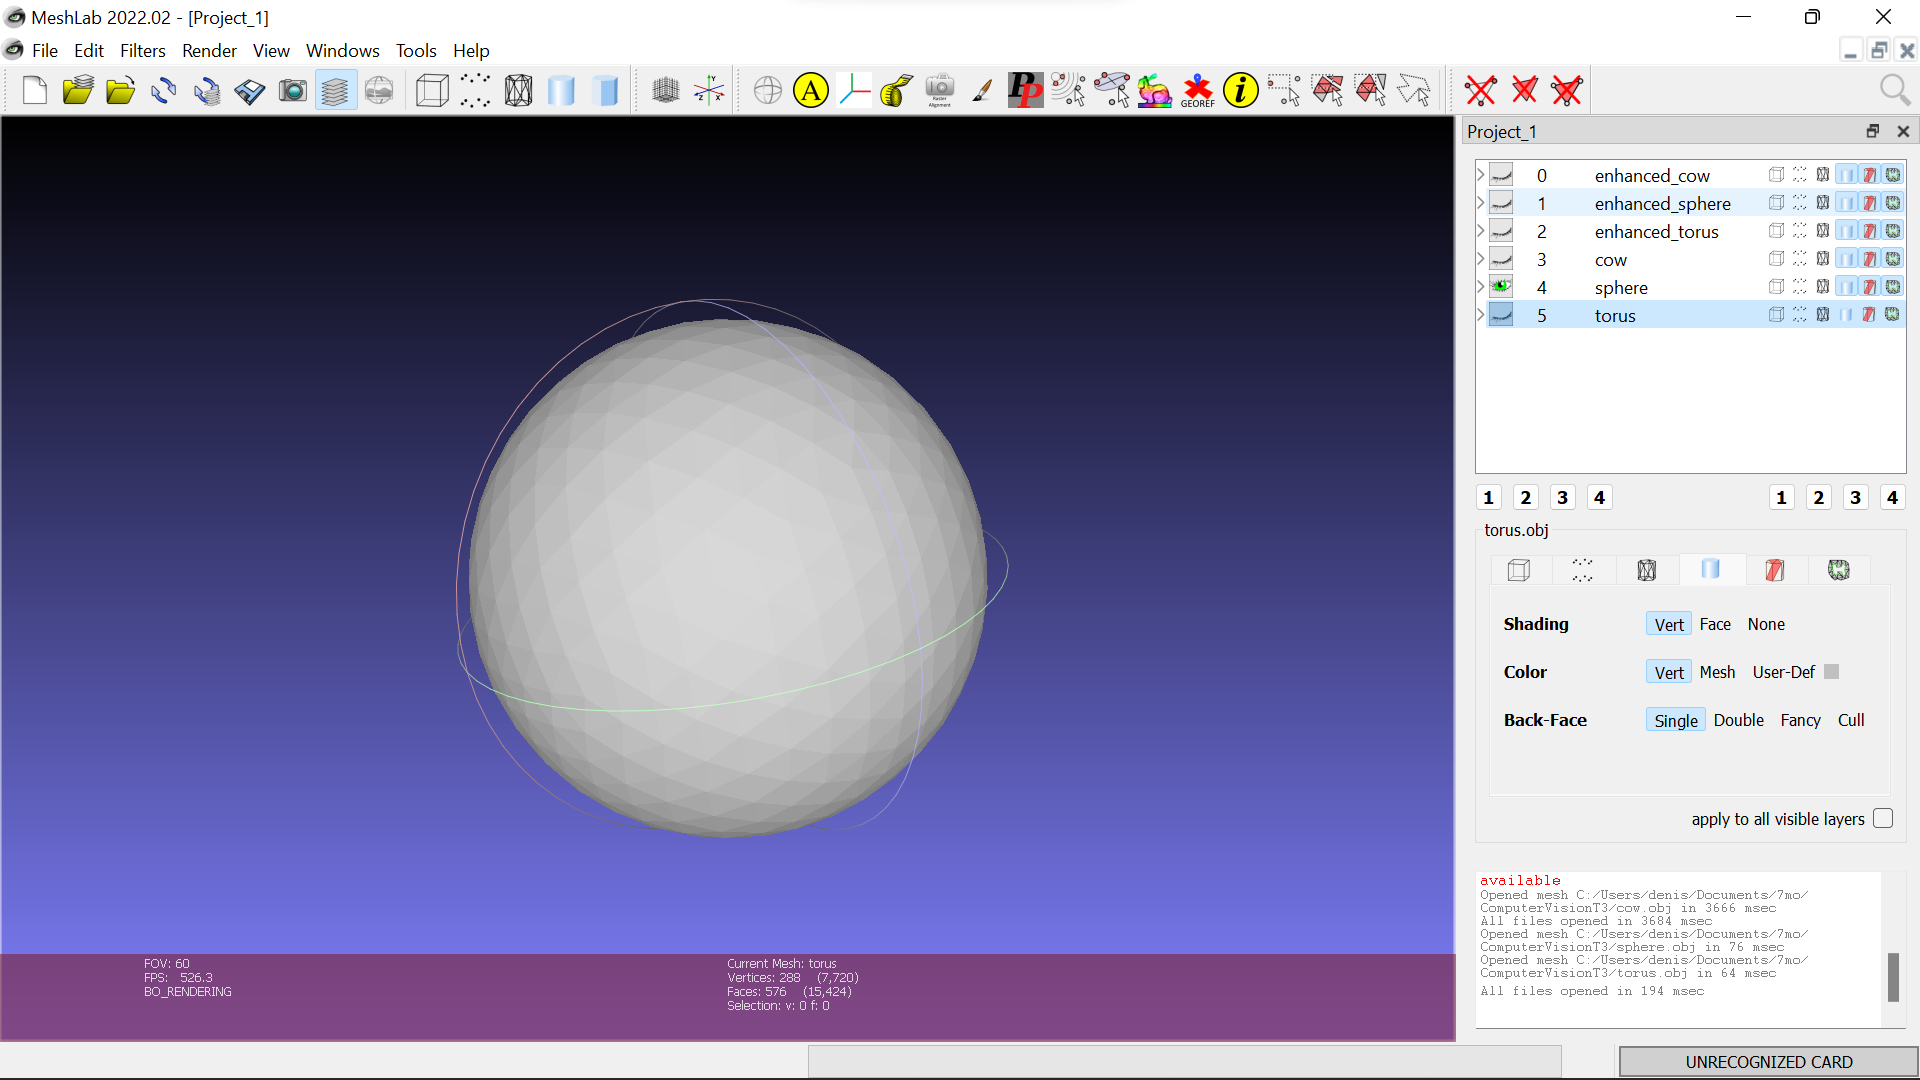

In [24]:
#Malla original
display.Image("./images/1.8.png", width=600)

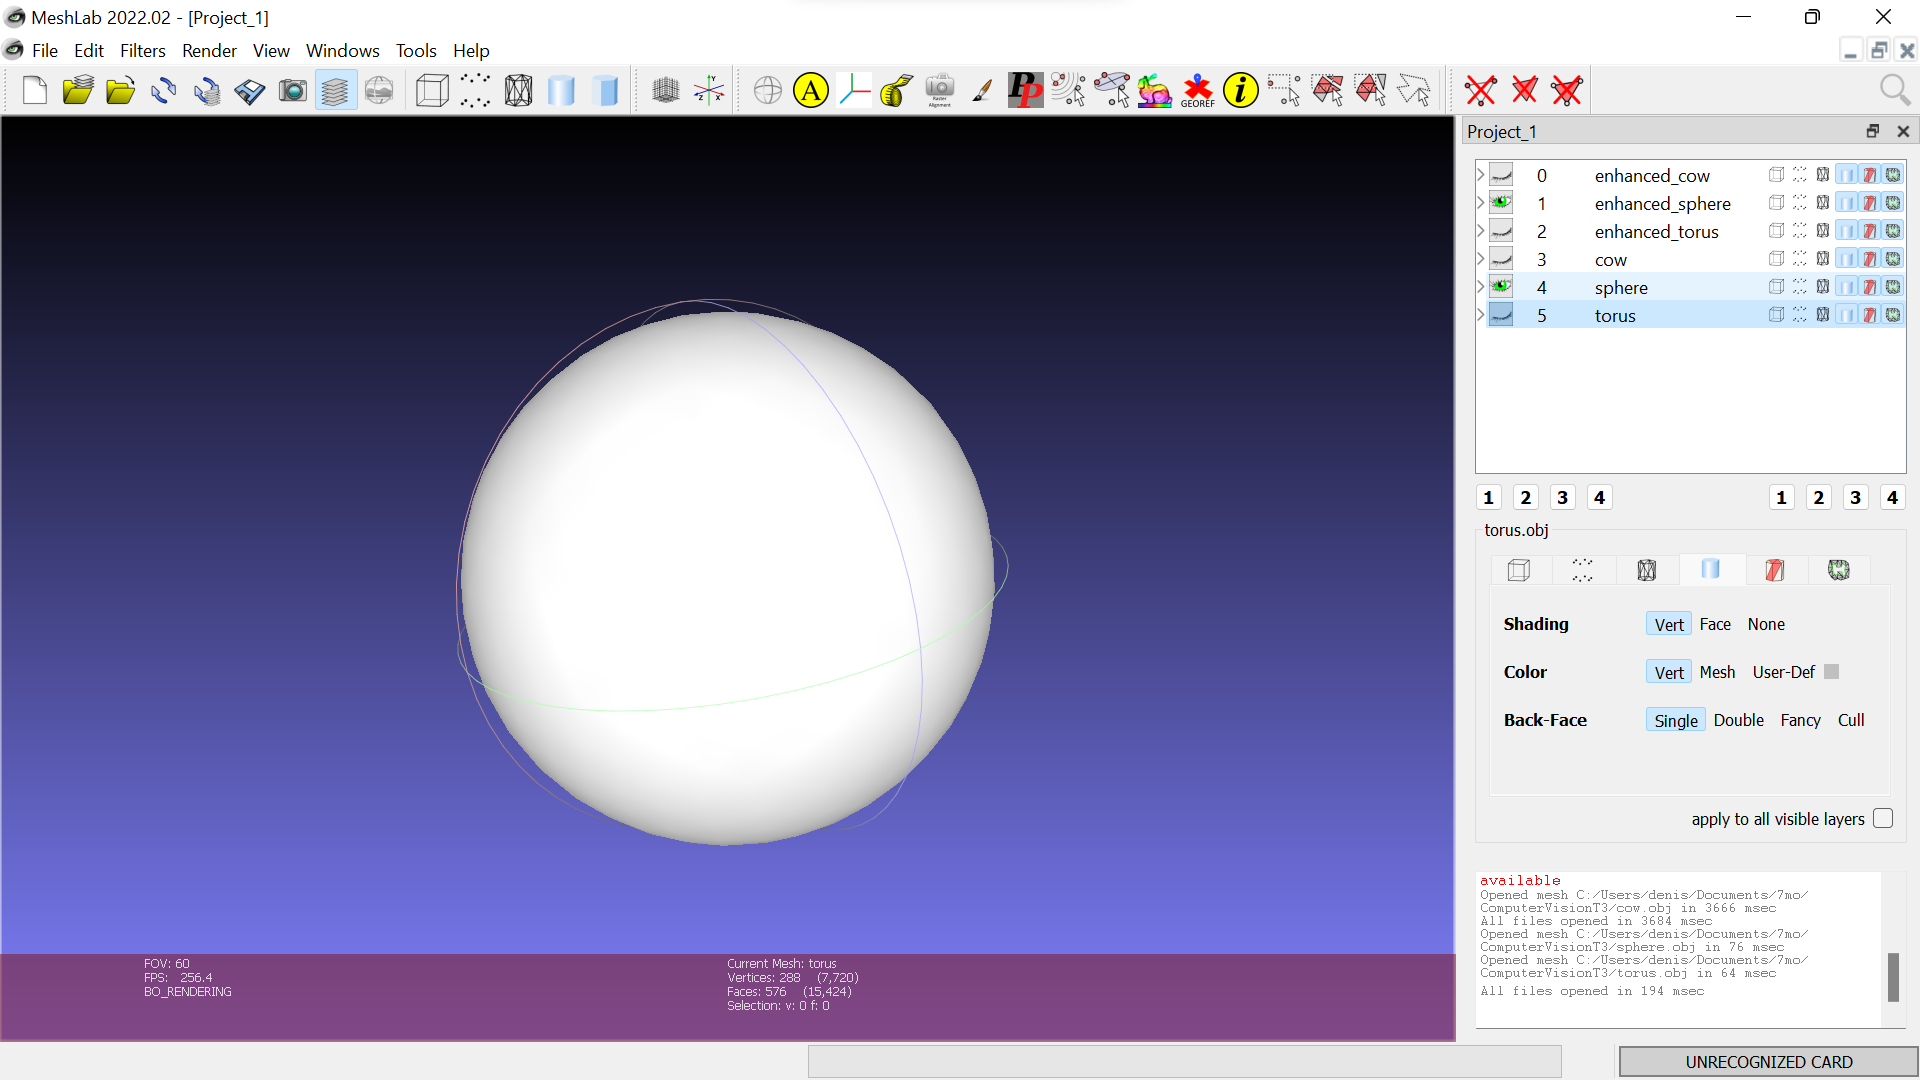

In [25]:
#Malla modificada
display.Image("./images/1.9.png", width=600)

In [26]:
enhanced_t = unsharp_masking_mesh("torus.obj", 2, 1, 1.5)

In [27]:
construct("torus.obj", enhanced_t, "enhanced_torus.obj")

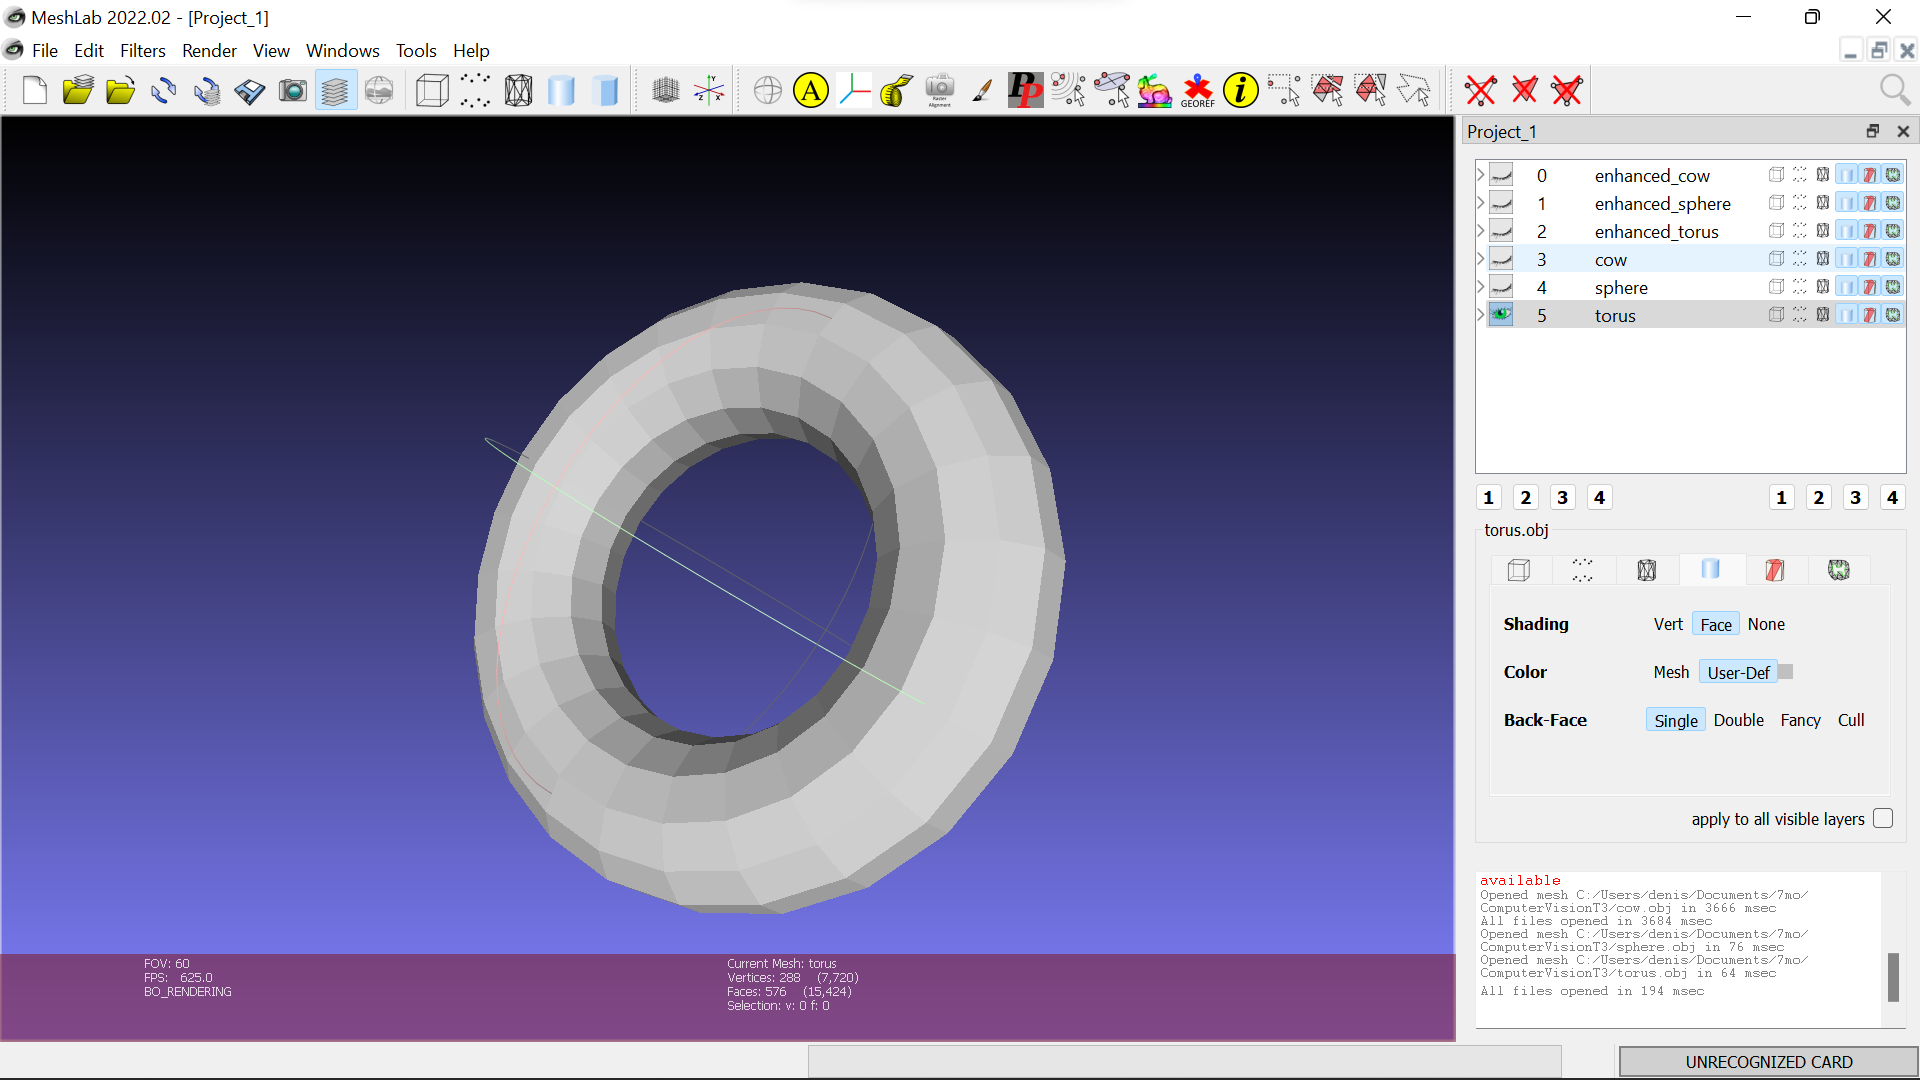

In [28]:
#Malla original
display.Image("./images/1.10.png", width=600)

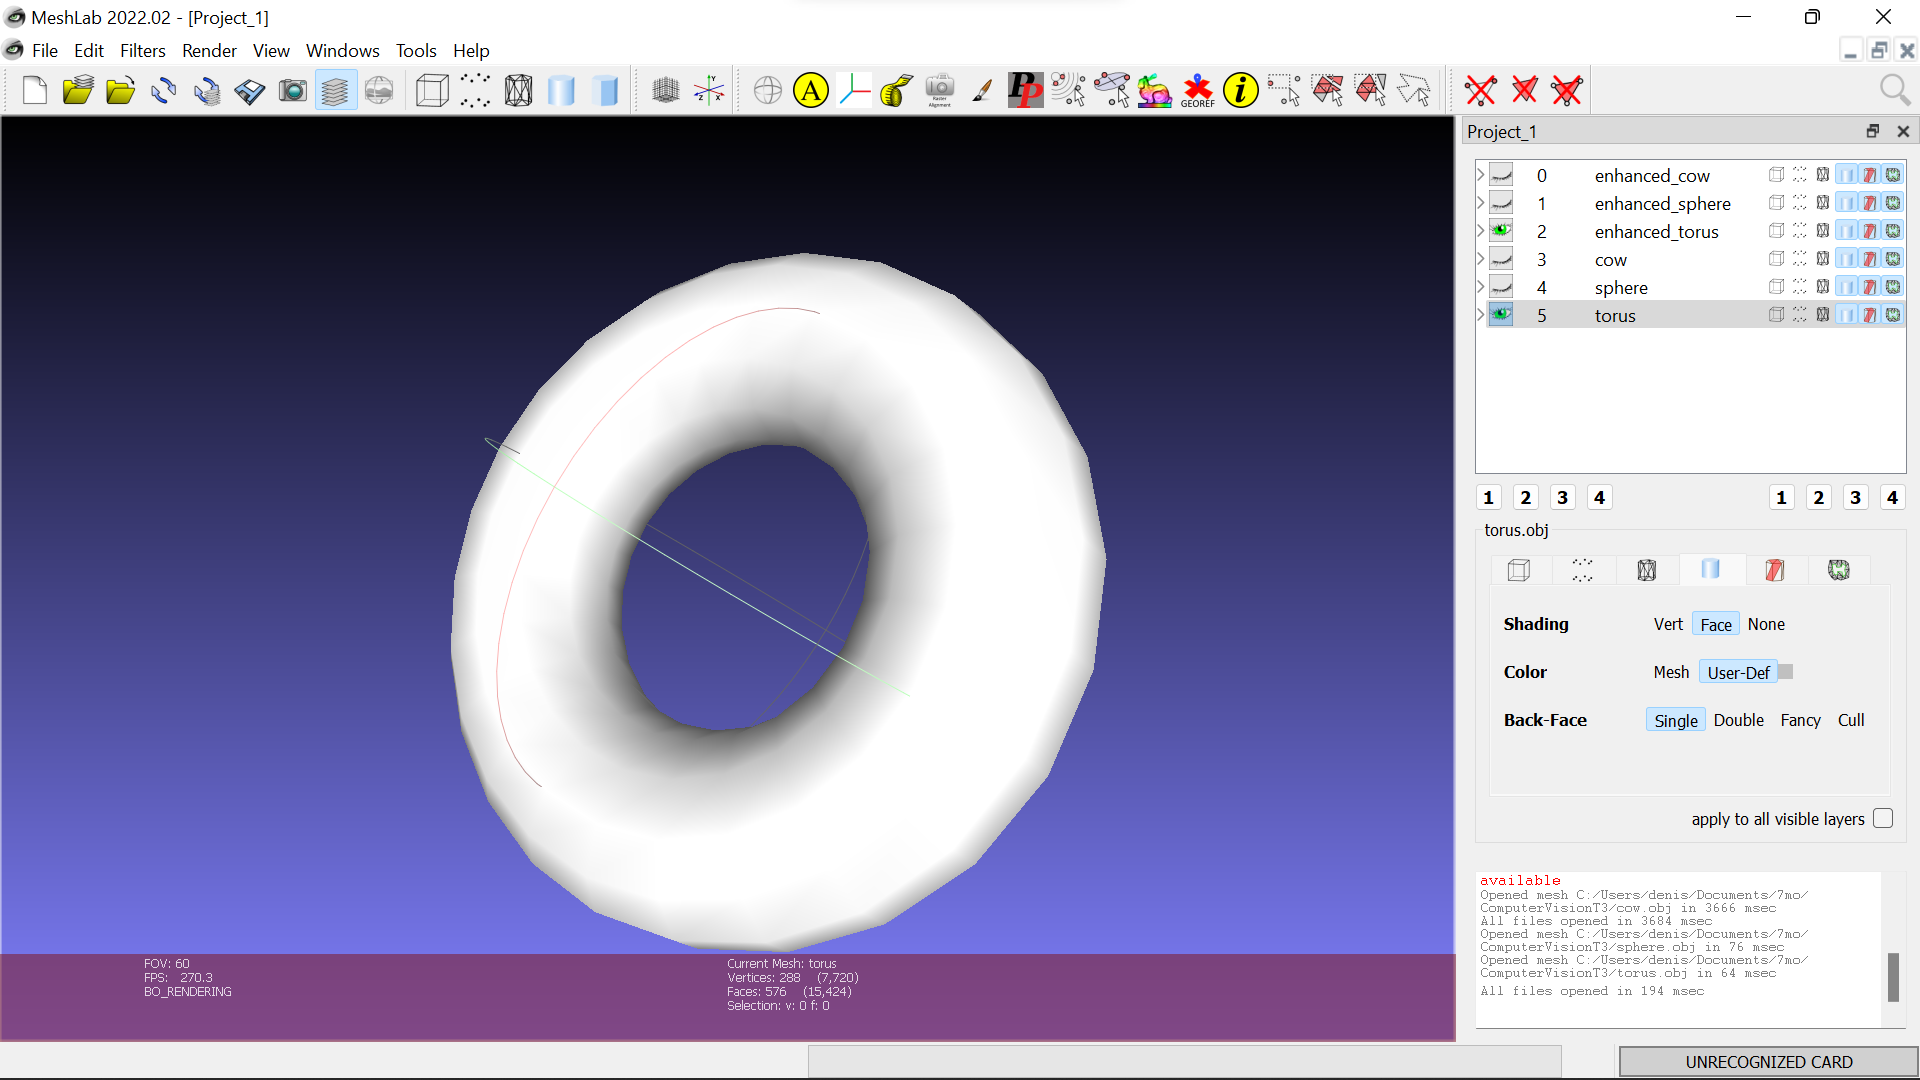

In [29]:
#Malla modificada
display.Image("./images/1.11.png", width=600)

Vemos que esta se ensanchó ligeramente.

## Ejercicio 2 (Shape generation)

Usamos las mismas funciones de la tarea pasada para calcular el Laplaciano discreto.

In [30]:
def angle(a, b, c): #ingresamos los 3 puntos del triangulo y nos devulve la cotangente
    #devuelve del angulo de enmedio
    ba = a - b
    bc = c - b
    cos_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cos_angle) #angulo en radianes
    return angle

def obtuso(a, b, c):
    an2 = angle(a, b, c)
    an1 = angle(b, a, c)
    an3 = angle(a, c, b)
    if(an1 > np.pi/2):
        return 1
    if(an2 > np.pi/2):
        return 2
    if(an3 > np.pi/2):
        return 3
    return 0

def cotangente(a,b,c):
    an = angle(a, b, c)
    cos_angle = np.sin(an)
    sin_angle = np.sin(an)
    return cos_angle/sin_angle

def area(v0, v1, v2): #area con formula de heron
    a = np.linalg.norm(v0-v1)
    b = np.linalg.norm(v2-v1)
    c = np.linalg.norm(v0-v2)
    s = (a+b+c)/2
    return np.sqrt(s*(s-a)*(s-b)*(s-c))

In [31]:
def area_cell(s): 
#Le pasamos el string del numbre del mesh que usaremos (debe estar en la misma carpeta que este archivo)
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
    n_vertex = ms.current_mesh().vertex_number() #obtenemos el numero de vertices
    n_faces = ms.current_mesh().face_number() #obtenemos el numero de caras
    voronoi = np.zeros(n_vertex) #creamos el arreglo que vamos a devolver, este es del tamaño de vertices
    faces = ms.current_mesh().face_matrix() #guardamos las caras
    vertex = ms.current_mesh().vertex_matrix() #guardamos los vertices
    angles_v = np.zeros(n_vertex)
    
    for i in range(n_faces): #Por cada cara
        #Guarda el indice de cada uno de los vertces que conforman la cara
        v0_in = faces[i][0]
        v1_in = faces[i][1]
        v2_in = faces[i][2]
        
        #Guarda las posiciones 3D de los vertices
        v0 = vertex[v0_in]
        v1 = vertex[v1_in]
        v2 = vertex[v2_in]
        
        #Guarda los angulos que forman en radianes
        a_0 = angle(v1, v0, v2)
        a_1 = angle(v0, v1, v2)
        a_2 = angle(v0, v2, v1)
        
        #Guarada la suma total de angulos
        angles_v[v0_in] += a_0
        angles_v[v1_in] += a_1
        angles_v[v2_in] += a_2
        
        #calculamos el cotangente
        cot_0 = np.cos(a_0)/np.sin(a_0)
        cot_1 = np.cos(a_1)/np.sin(a_1)
        cot_2 = np.cos(a_2)/np.sin(a_2)
        
        #checamos si es obtuso el angulo, y nos devuelve cual es el obtuso
        ob = obtuso(v0, v1, v2)
        #calculamos el area del triangulo
        area_t = area(v0, v1, v2)
        
        if(ob == 0): #Si no tiene ningun angulo obtuso, a cada angulo le sumamos el area correspondiente
            voronoi[v0_in] += (1/8)*(cot_1)*(np.linalg.norm(v0-v2))**2
            voronoi[v0_in] += (1/8)*(cot_2)*(np.linalg.norm(v0-v1))**2
            
            voronoi[v1_in] += (1/8)*(cot_0)*(np.linalg.norm(v1-v2))**2
            voronoi[v1_in] += (1/8)*(cot_2)*(np.linalg.norm(v1-v0))**2
            
            voronoi[v2_in] += (1/8)*(cot_0)*(np.linalg.norm(v2-v1))**2
            voronoi[v2_in] += (1/8)*(cot_1)*(np.linalg.norm(v2-v0))**2
        else:
            if(ob == 1):
                voronoi[v0_in] += area_t/2 #Si es el vertice central el que es obtuso, el area es /2
                voronoi[v1_in] += area_t/4
                voronoi[v2_in] += area_t/4
            if(ob == 2):
                voronoi[v0_in] += area_t/4
                voronoi[v1_in] += area_t/2
                voronoi[v2_in] += area_t/4
            if(ob == 3):
                voronoi[v0_in] += area_t/4
                voronoi[v1_in] += area_t/4
                voronoi[v2_in] += area_t/2
    return voronoi, angles_v #devuelve el area voronoi y la suma de angulos al rededor de un vertice

In [32]:
def laplace_beltrami_matrix_1(s):
    #Le pasamos el string del numbre del mesh que usaremos (debe estar en la misma carpeta que este archivo)
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
    voronoi, angles = area_cell(s)
    
    n_vertex = ms.current_mesh().vertex_number() #obtenemos el numero de vertices
    n_faces = ms.current_mesh().face_number() #obtenemos el numero de caras
    faces = ms.current_mesh().face_matrix() #guardamos las caras
    vertex = ms.current_mesh().vertex_matrix() #guardamos los vertices
    
    M = np.zeros((n_vertex, n_vertex))
    C = np.zeros((n_vertex, n_vertex))
    
    for i in range(n_faces): #Por cada cara 
        v0_in = faces[i][0]
        v1_in = faces[i][1]
        v2_in = faces[i][2]
        
        v0 = vertex[v0_in]
        v1 = vertex[v1_in]
        v2 = vertex[v2_in]
        
        cot_0 = cotangente(v1, v0, v2)
        cot_1 = cotangente(v0, v1, v2)
        cot_2 = cotangente(v0, v2, v1)
        
        ob = obtuso(v0, v1, v2)
        area_t = area(v0, v1, v2)
        
        if(M[v0_in][v0_in] == 0):
            M[v0_in][v0_in] = np.abs(voronoi[v0_in])
        if(M[v1_in][v1_in] == 0):
            M[v1_in][v1_in] = np.abs(voronoi[v1_in])
        if(M[v2_in][v2_in] == 0):
            M[v2_in][v2_in] = np.abs(voronoi[v2_in])
        
        C[v0_in][v1_in] += (0.5)*cot_2
        C[v0_in][v2_in] += (0.5)*cot_1
        C[v0_in][v0_in] -= (0.5)*(C[v0_in][v1_in] + C[v0_in][v2_in])
        
        C[v1_in][v0_in] += (0.5)*cot_2
        C[v1_in][v2_in] += (0.5)*cot_0
        C[v1_in][v1_in] -= (0.5)*(C[v1_in][v0_in] + C[v1_in][v2_in])
        
        C[v2_in][v0_in] += (0.5)*cot_1
        C[v2_in][v1_in] += (0.5)*cot_0
        C[v2_in][v2_in] -= (0.5)*(C[v2_in][v0_in] + C[v2_in][v1_in])
        
    return np.linalg.inv(M)@C

Buscamos la eigenfuncion $\Phi$ tal que para
$$H^i = -\frac{1}{2}(C^i + {C^i}^T) $$
donde $C^i$ es la matriz del Laplaciano-Beltrami de la malla $M^i$, se tenga que
$$H\Phi = \lambda\Phi $$
donde $\lambda$ es un eigenvalor.

Sabemos que para el Laplaciano discreto las funciones $\Phi$ buscadas serán los vectores propios de la matriz del Laplaciano discreto.

Además de que la k-ésima entrada del vector propio $e_i$ corresponderá a la amplitud de la onda $e_i$ del vertice $v_k$ y la frecuencia $f$ de la onda es determinada por el eigenvector $\lambda_i$.

In [33]:
def eigenfunctions(s):
    C = laplace_beltrami_matrix_1(s)
    H = -(0.5)*(C + np.transpose(C))

    #usamos la libreria linalg de numpy para calcular los eigenvectores
    #la funcion nos devolvera eigenvalores y eigenvectores, por lo que solo nos interesa phi[1]
    phi = np.linalg.eig(H)
    
    return phi[1]

In [34]:
phi = eigenfunctions("sphere.obj")

In [35]:
ms = pymeshlab.MeshSet() 
ms.load_new_mesh("sphere.obj") #cargamos el mesh
ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    
vertex = ms.current_mesh().vertex_matrix() 

Un eigenvector cumple la propiedad de que
$$A\vec{v} = \lambda\vec{v}.$$
Ya que los eigenvectores del Laplaciano discreto forman una base ortonormal para $f = (f_1, \dots, f_n)^T$, entonces podemos representar a está función como
$$ f = \sum_{i=1}^{n}\langle e_i, f \rangle e_i$$
con $\langle e_i, f \rangle = e_i^Tf$

Ya que buscamos 
$$ \vec{x} = \sum_{i=1}^{n}\langle e_i, x \rangle e_i, \hspace{1cm} \vec{y} = \sum_{i=1}^{n}\langle e_i, y \rangle e_i, \hspace{1cm}  \vec{z} = \sum_{i=1}^{n}\langle e_i, z \rangle e_i$$
Primero es necesario separar por coordenadas.

In [36]:
#devuelve los coeficientes con una funcion 
def coefficients(s, f):
    #le pasamos la malla y la funcion
    
    #separamos por coordenadas
    split = np.transpose(f)
    
    phi = eigenfunctions(s)
    n = len(f)
    m = len(f[0])
    coef = np.zeros((m, n))
    for j in range(m):
        for i in range(n):
            coef[j][i] = np.dot(phi[i],split[j])
            
    return coef

In [37]:
coef = coefficients("sphere.obj", vertex)

In [38]:
#Tiene 3 vectores con los coeficientes de cada coordenada 
#los coeficientes del vertice i son (coef[0][i], coef[1][i], coef[2][i])
coef.shape

(3, 642)

In [39]:
def vertex_array(phi, coef):
    #Le pasamos los vectores propios y los coeficientes y nos devuelve la funcion en esa base
    n = len(coef) #numero de coordenadas
    m = len(coef[0]) #numero de vertices
    x = np.zeros((n,m))
    for i in range(n):
        x[i] = coef[0]*phi[0]
        for j in range(1, m):
            x[i] +=  coef[i][j]*phi[j]
    return np.transpose(x)

In [40]:
def frecuency_transfer(s1, s2, K):
    #recibe el nombre de mesh1 y mesh2, y un entero K
    
    ms = pymeshlab.MeshSet() 
    ms.load_new_mesh(s1) #cargamos el mesh
    ms.load_new_mesh(s2) #cargamos el mesh
    ms.set_current_mesh(0) #decimos que este es el mesh que estaremos usando
    vertex_1 = ms.current_mesh().vertex_matrix() #guardamos las caras
    ms.set_current_mesh(1) #decimos que este es el mesh que estaremos usando
    vertex_2 = ms.current_mesh().vertex_matrix() #guardamos las caras
    n = len(vertex_2)
    
    coef_1 = coefficients(s1, vertex_1)
    coef_2 = coefficients(s2, vertex_2)
    
    coef_3 = np.zeros(coef_2.shape)
    
    
    for i in range(n):
        if(i<=K):
            for j in range(len(coef_3)):
                    coef_3[j][i] = coef_1[j][i]
        else:
            for j in range(len(coef_3)):
                    coef_3[j][i] = coef_2[j][i]
    
    phi = eigenfunctions(s2)
    vertex_3 = vertex_array(phi, coef_3)
    
    return vertex_3

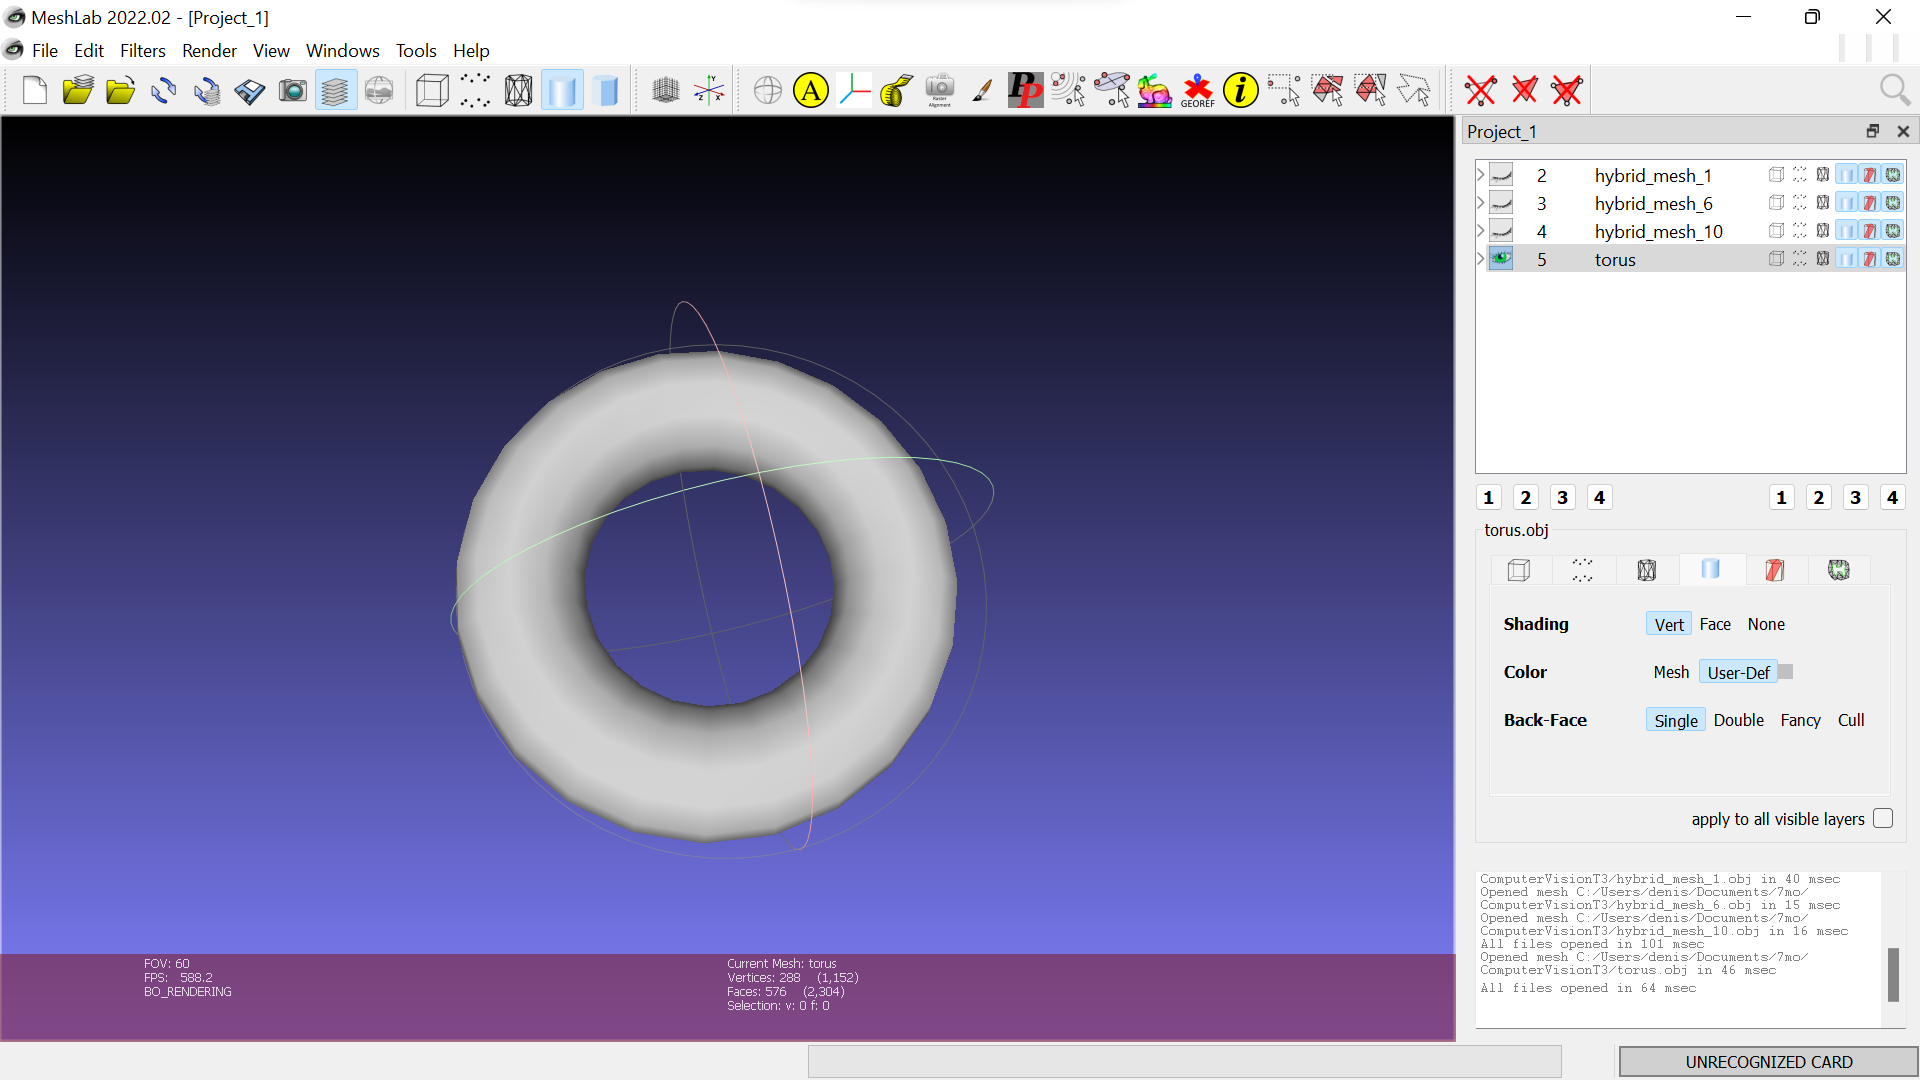

In [41]:
#Malla original
display.Image("./images/2.1.png", width=600)

In [42]:
v = frecuency_transfer("sphere.obj", "torus.obj", 1)
construct("torus.obj", v, "hybrid_mesh_1.obj")

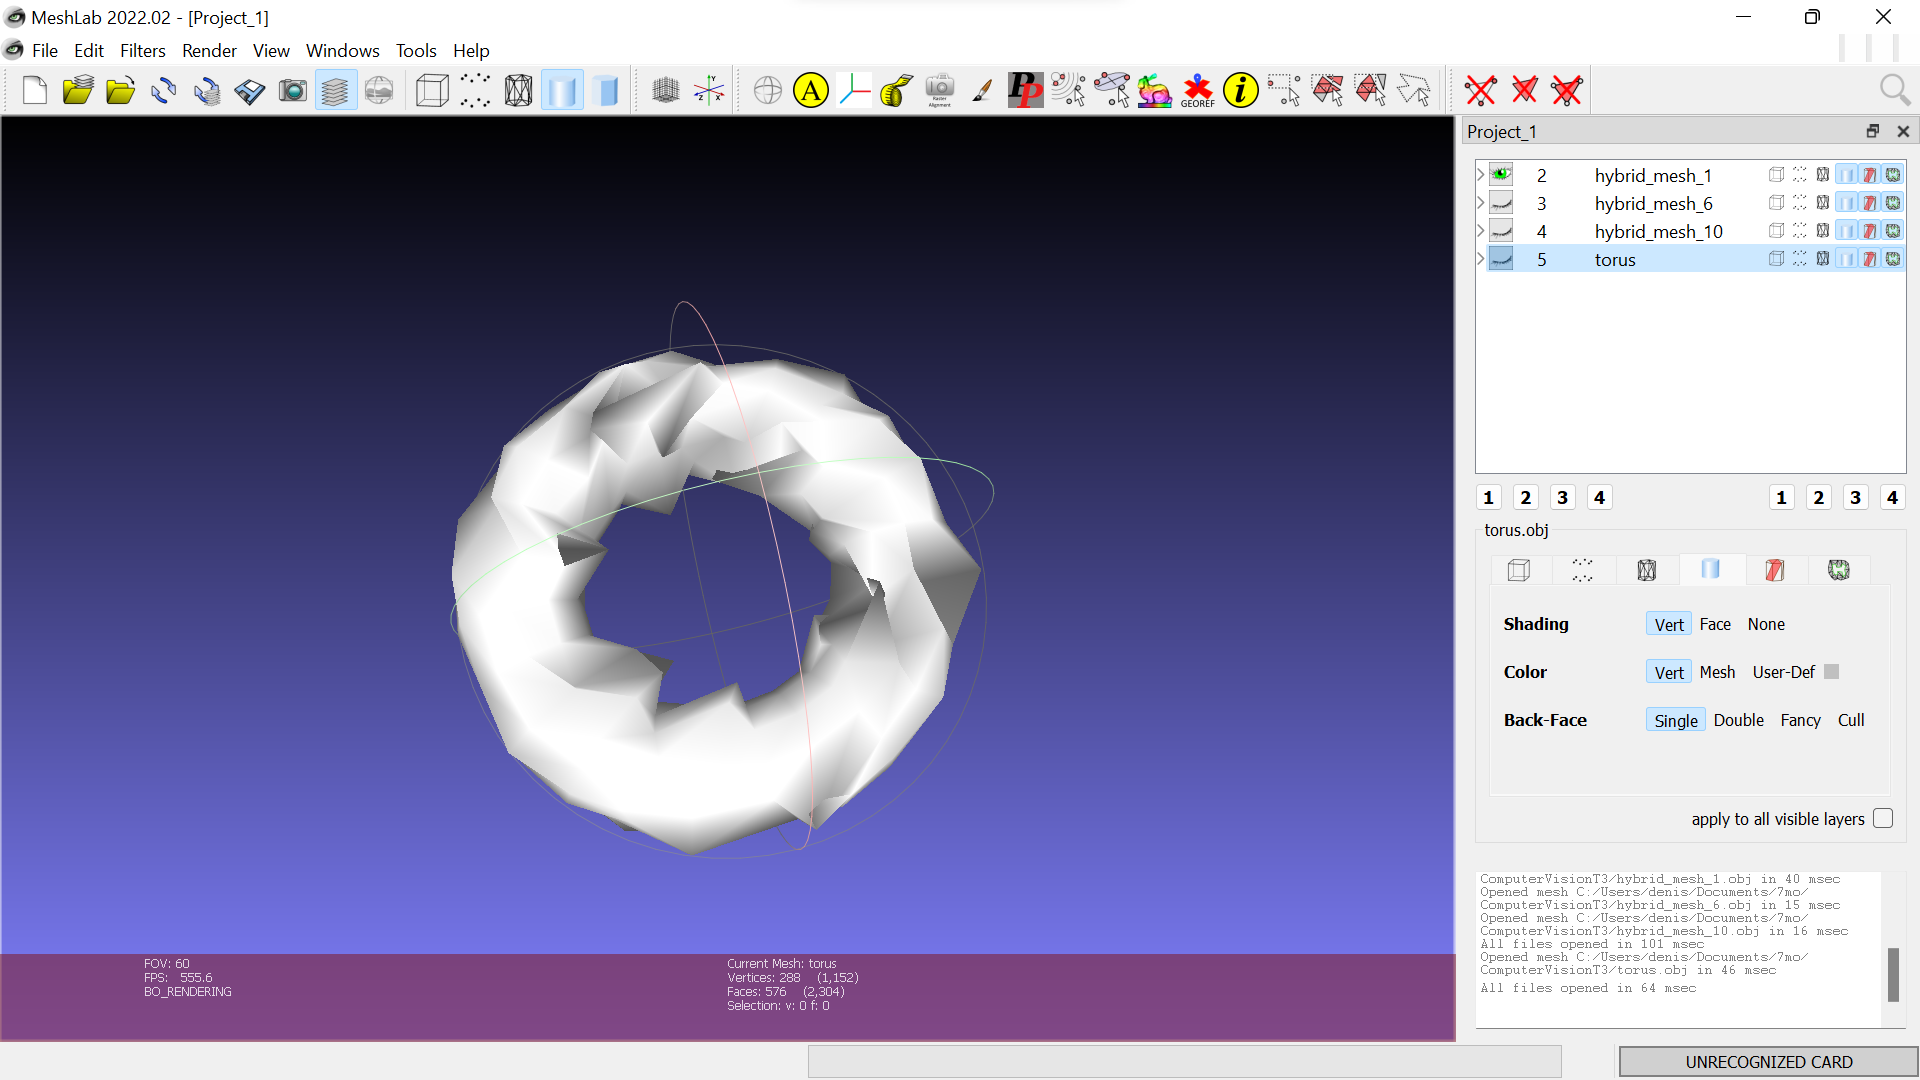

In [43]:
#Malla con K=1
display.Image("./images/2.2.png", width=600)

In [44]:
v = frecuency_transfer("sphere.obj", "torus.obj", 6)
construct("torus.obj", v, "hybrid_mesh_1.obj")

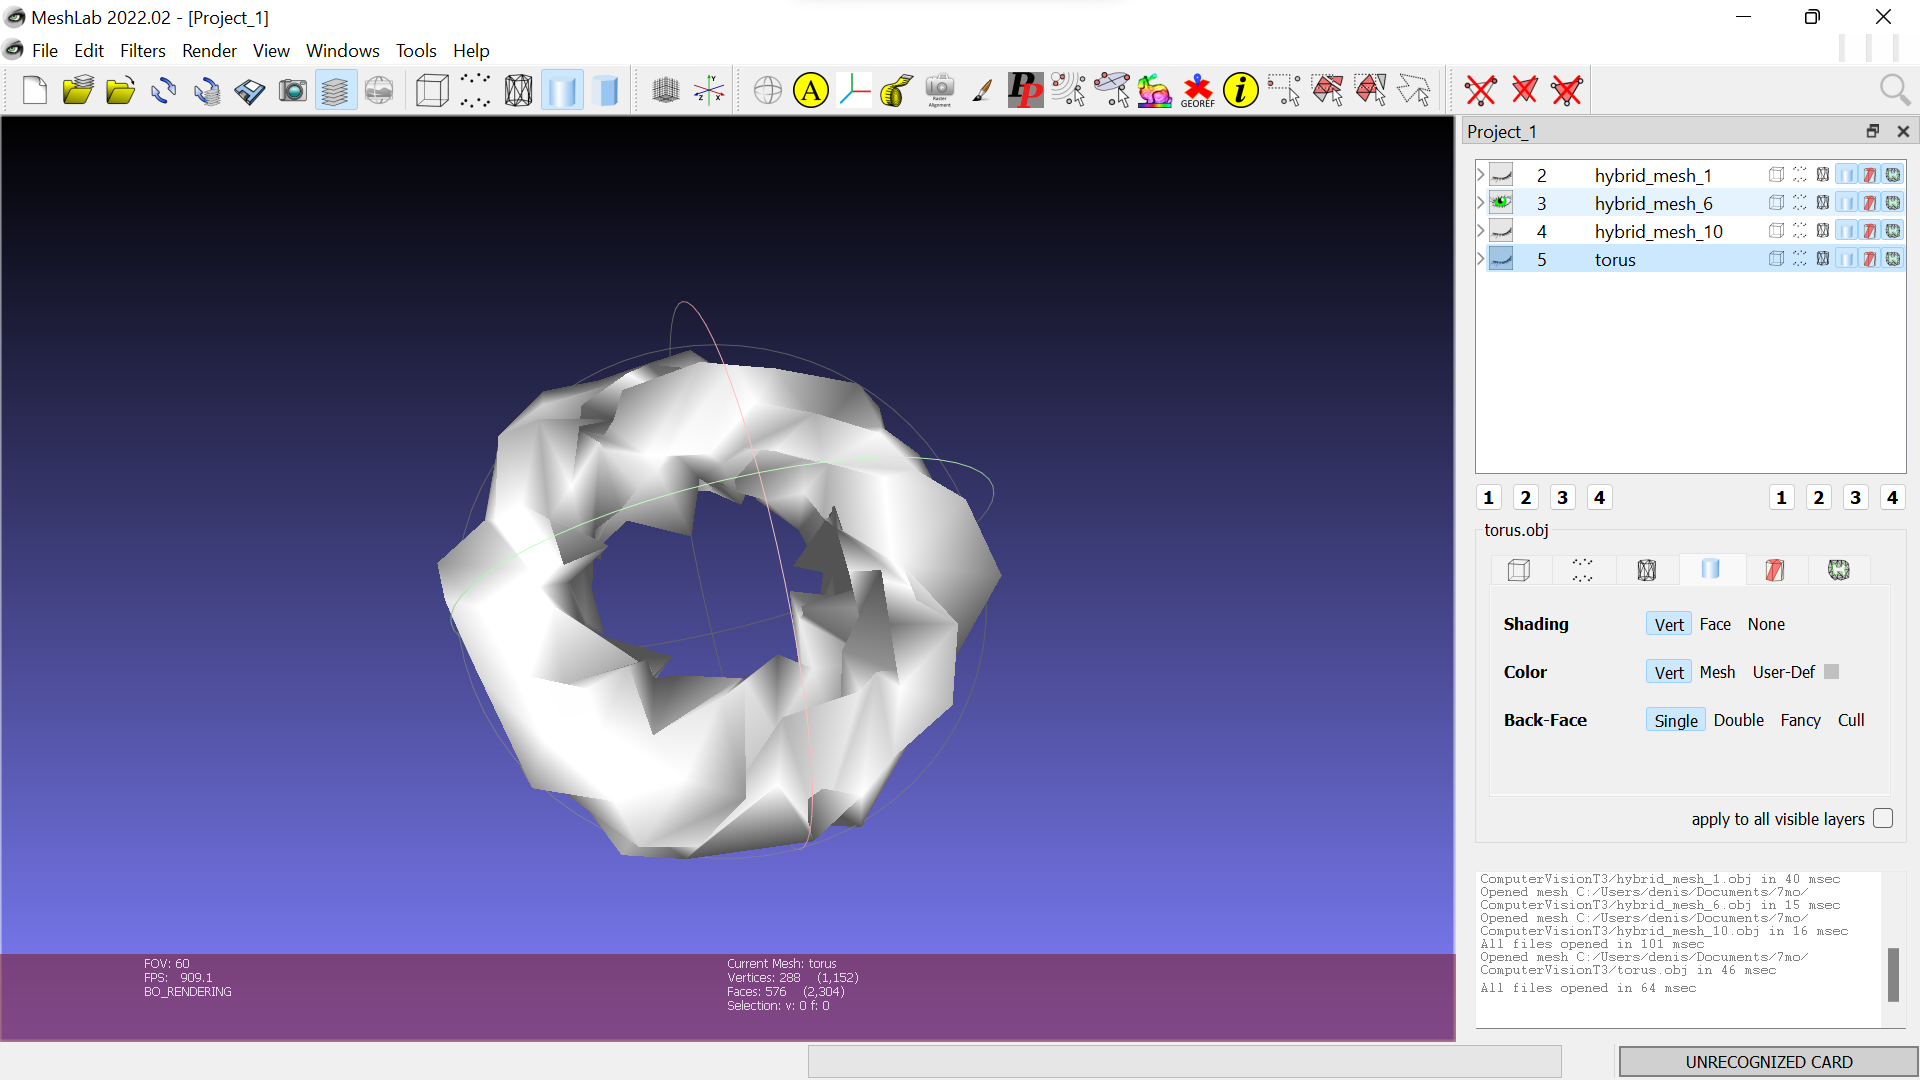

In [45]:
#Malla con K=6
display.Image("./images/2.3.png", width=600)

In [46]:
v = frecuency_transfer("sphere.obj", "torus.obj", 10)
construct("torus.obj", v, "hybrid_mesh_1.obj")

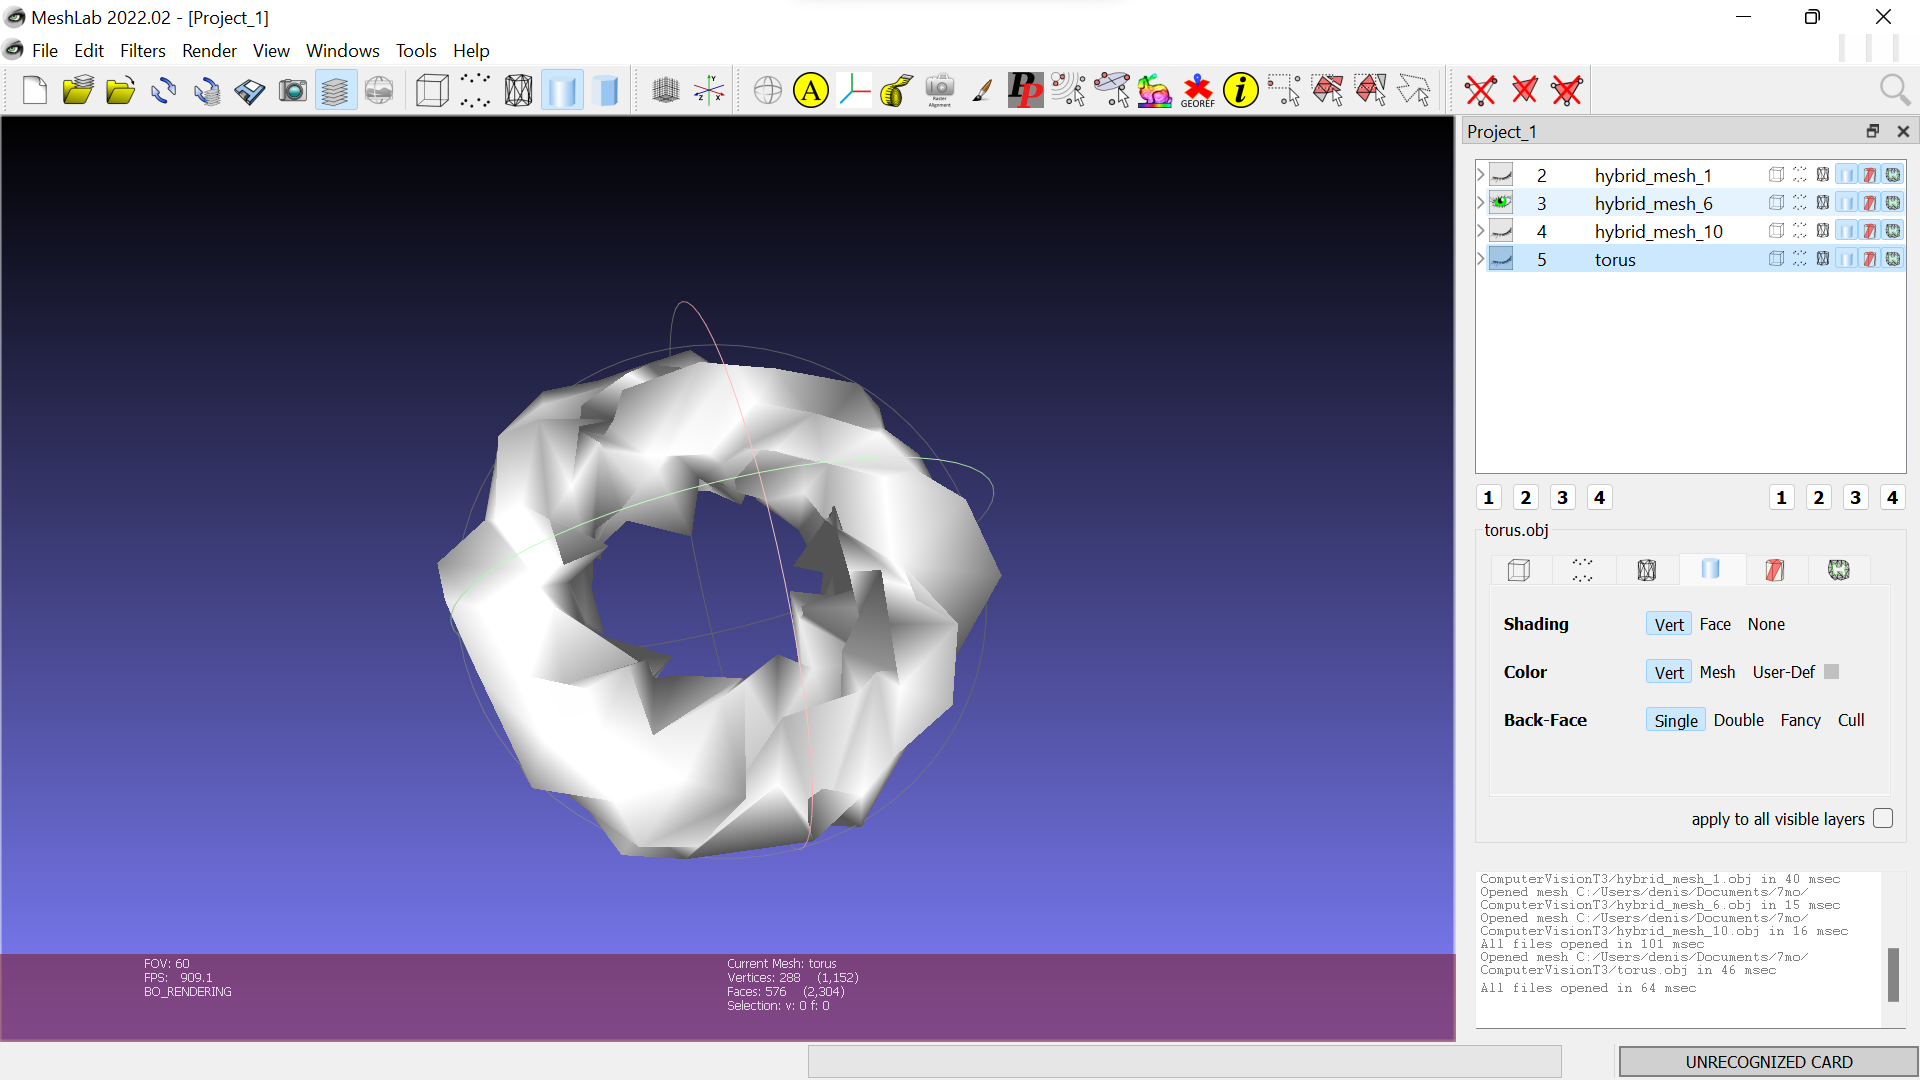

In [47]:
#Malla con K=10
display.Image("./images/2.3.png", width=600)

## Ejercicio 3 (Shape classification)

In [48]:
import os
def g_curvature(folder_name):
    ms = pymeshlab.MeshSet() 
    #ms.load_new_mesh(folder_name + i +".ply")
    dir_list = os.listdir(folder_name)
    K_1 = []
    aux = int(0)
    mini = 100000
    for i in dir_list:
        ms.load_new_mesh("chairs/" + i) #cargamos el mesh
        ms.set_current_mesh(aux)
        K_1.append(ms.current_mesh().vertex_scalar_array())
        if(len(K_1[aux])<mini):
            mini = len(K_1[aux])
        aux += 1
        
    #Ya que las mallas no tienen el mismo tamaño las corte para que fueran del mismo tamaño
    K = np.zeros((aux, mini))
    for i in range(aux):
        for j in range(mini):
            K[i][j] = K_1[i][j]
    return K

In [49]:
K = g_curvature("chairs/")

In [50]:
K.shape

(20, 5000)

In [51]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(K)

In [52]:
kmeans.cluster_centers_

array([[ 8.70879593e-02, -2.77792179e-02, -2.90280945e-03, ...,
        -3.50588628e-02, -8.74418341e-05,  5.05408353e-05],
       [ 9.25239903e-02,  1.26437692e-01,  8.82881346e-02, ...,
         8.58452976e-04,  6.92830565e-03, -2.14743131e-02],
       [ 1.26410296e-01, -4.36781678e-02,  1.30825002e-02, ...,
         8.01877340e-04, -4.23033898e-01, -1.91623955e-02],
       [ 1.53644599e-03,  1.57201087e-02,  6.07818649e-05, ...,
        -9.57644590e-02, -1.93301668e-02,  5.93545984e-04],
       [ 6.65373438e-02, -6.39142262e-03,  2.68565632e-02, ...,
        -1.73990538e-01, -1.15834816e-01, -5.48338695e-02]])

En general, el algoritmo KMeans agrupa los datos tratando de separar muestras en $n$ grupos de igual varianza, minimizando la suma de cuadrados dentro del grupo.

Funciona dividiendo un conjunto de muestras en grupos separados, cada uno descrito por la media de las muestras en el grupo. Los medios se denominan comúnmente "centroides" del grupo. Es decir, el centroide es la media de todos los puntos en el cluster